# Análisis exploratorio de datos del Futuro del crudo.
""https://chatgpt.com/c/bb82dd63-4fc8-4c12-b369-0a545de4c585""

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from scipy.stats import binom   
import datetime

# Preparación del dataset, webscraping, merges...

In [4]:
#Descargamos datos del CL la bibilioteca de yfinance.
df = yf.download("CL=F", start="2014-01-01", end="2024-08-01")
df = df.reset_index()

# Descargar datos del eurodólar
df_eurusd = yf.download("6E=F", start="2014-01-01", end="2024-08-01")
df_eurusd = df_eurusd.reset_index()

#Descagar datos del ES
df_sp500 = yf.download("ES=F", start="2014-01-01", end="2024-08-01")
df_sp500 = df_sp500.reset_index()


# Descargar datos históricos de XLE (Energy Select Sector SPDR Fund)
df_xle = yf.download("XLE", start="2014-01-01", end="2024-08-01")
df_xle = df_xle.reset_index()


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index 

### Merges de los cierres del Sp500, EURUSD, XLE. para futuro analísis de correlación.

In [5]:
#Convertimos fechas a datetime.
df_eurusd['Date'] = pd.to_datetime(df_eurusd['Date'])
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])
df_xle['Date'] = pd.to_datetime(df_xle['Date'])

# Renombrar las columnas 'Close' de los otros DataFrames antes de hacer el merge
df_eurusd.rename(columns={'Close': 'Close_eurusd'}, inplace=True)
df_sp500.rename(columns={'Close': 'Close_sp500'}, inplace=True)
df_xle.rename(columns={'Close': 'Close_xle'}, inplace=True)

# Combinar df (petróleo) y df_eur_usd (eurodólar)
df_merged = pd.merge(df, df_eurusd[['Date', 'Close_eurusd']], on='Date', how='inner')

# Combinar el resultado con df_sp500 (S&P 500)
df_merged = pd.merge(df_merged, df_sp500[['Date', 'Close_sp500']], on='Date', how='inner')

# Combinar el resultado con df_xle (XLE)
df_merged = pd.merge(df_merged, df_xle[['Date', 'Close_xle']], on='Date', how='inner')

# Renombramos dataframe original.
df = df_merged

### Importación, normalización y merge del dataset de de las noticias de la EIA.

In [6]:
#Importamos el dataset scrapeado de noticias de la EIA
df_eia = pd.read_csv("eia_today_in_energy_with_corrected_dates.csv")

# Convertir fechas a formato date_time
df_eia['fechas_noticia_EIA'] = pd.to_datetime(df_eia['fechas_noticia_EIA'])

# Filtrar por el rango de fechas de mi dataset del CL
df_eia = df_eia[(df_eia['fechas_noticia_EIA'] >= '2014-01-01') & (df_eia['fechas_noticia_EIA'] <= '2024-08-01')]

df = pd.merge(df, df_eia[['fechas_noticia_EIA', 'Noticia_EIA']], left_on='Date', right_on='fechas_noticia_EIA', how='left')
# Eliminar la columna 'fechas_noticia_EIA' 
df = df.drop('fechas_noticia_EIA', axis=1)

df_eia

,Noticia_EIA,fechas_noticia_EIA
3,Canada's crude oil has an increasingly signifi...,2024-08-01
4,Energy trade value between Mexico and the Unit...,2024-07-15
5,U.S. energy production exceeded consumption by...,2024-06-26
6,U.S. refinery capacity increased 2% in 2023,2024-06-18
7,EIA expands coverage of crude oil and natural ...,2024-06-12
...,...,...
479,Five states and the Gulf of Mexico produce mor...,2014-03-31
480,Tight oil production pushes U.S. crude supply ...,2014-03-26
481,Brent crude oil trading range in 2013 was narr...,2014-03-04
482,Gasoline prices moved in tight range in 2013,2014-01-10


### Importación y left join, de dataset con datos macro de inventario semanal, producción, importación y exportación.

In [7]:
#Importamos el dataset con los datos macro
df_macro = pd.read_csv("macro_cl.csv")
#Convertimos a formato datetime para poder hacer el merge correctamente
df_macro["Date"] = pd.to_datetime(df_macro["Date"])

#Borramos la columna "inventario_semanal" ya que esta con la fecha incorrecta
df_macro.drop(columns="inventario_final_semanal", inplace=True)

#Hacemos el left join
df = pd.merge(df,df_macro, on="Date", how="left")

In [8]:
#Importamos el dataset con los datos del inventario con las fechas correctas.
inventario = pd.read_csv("inventario_cl.csv")

# Convertimos fechas a datetime
inventario["Date"] = pd.to_datetime(inventario["Date"])

#Hacemos el  left join
df = pd.merge(df,inventario, on="Date", how="left")

# Información general del Dataset.

In [9]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Close_eurusd,Close_sp500,Close_xle,Noticia_EIA,produccion_diaria_promedio,importacion_diaria_promedio,exportacion_diaria_promedio,inventario_final_semanal
0,2014-01-02,98.500000,98.970001,95.339996,95.440002,95.440002,251248,1.3652,1826.50,87.250000,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,95.470001,95.739998,93.860001,93.959999,93.959999,215522,1.3598,1825.50,86.930000,NaN,8145.0,7961.0,58.0,326737.0
2,2014-01-06,94.180000,94.589996,93.199997,93.430000,93.430000,189379,1.3635,1820.75,87.050003,Change in energy prices mixed in 2013 as price...,NaN,NaN,NaN,NaN
3,2014-01-07,93.599998,94.220001,93.349998,93.669998,93.669998,177182,1.3617,1830.75,87.709999,NaN,NaN,NaN,NaN,NaN
4,2014-01-08,93.959999,94.180000,92.260002,92.330002,92.330002,244855,1.3582,1832.50,87.099998,NaN,NaN,NaN,NaN,326737.0


In [10]:
#Info basica tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         2662 non-null   datetime64[ns]
 1   Open                         2662 non-null   float64       
 2   High                         2662 non-null   float64       
 3   Low                          2662 non-null   float64       
 4   Close                        2662 non-null   float64       
 5   Adj Close                    2662 non-null   float64       
 6   Volume                       2662 non-null   int64         
 7   Close_eurusd                 2662 non-null   float64       
 8   Close_sp500                  2662 non-null   float64       
 9   Close_xle                    2662 non-null   float64       
 10  Noticia_EIA                  480 non-null    object        
 11  produccion_diaria_promedio   532 non-null  

In [11]:
#No hay valores faltantes
df.isnull().sum()

Date                              0
Open                              0
High                              0
Low                               0
Close                             0
Adj Close                         0
Volume                            0
Close_eurusd                      0
Close_sp500                       0
Close_xle                         0
Noticia_EIA                    2182
produccion_diaria_promedio     2130
importacion_diaria_promedio    2130
exportacion_diaria_promedio    2130
inventario_final_semanal       2109
dtype: int64

In [12]:
#No hay valores duplciados.
df.duplicated().sum()

2

In [13]:
#Descripción estadistica del dataset.
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_eurusd,Close_sp500,Close_xle,produccion_diaria_promedio,importacion_diaria_promedio,exportacion_diaria_promedio,inventario_final_semanal
count,2662,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2.662000e+03,2662.000000,2662.000000,2662.000000,532.000000,532.000000,532.000000,553.000000
mean,2019-04-17 18:52:44.537941504,64.625567,65.669936,63.495800,64.584207,64.584207,4.484550e+05,1.141037,3128.444380,69.536604,10768.765038,6985.109023,2207.798872,443869.972875
min,2014-01-02 00:00:00,-14.000000,13.690000,-40.320000,-37.630001,-37.630001,0.000000e+00,0.961350,1732.750000,23.570000,8044.000000,4599.000000,58.000000,319079.000000
25%,2016-08-23 06:00:00,49.082501,49.795001,48.219999,49.099998,49.099998,2.944508e+05,1.088663,2145.812500,60.702500,9217.000000,6331.250000,555.250000,422086.000000
50%,2019-04-20 00:00:00,61.400000,62.065001,60.440001,61.410000,61.410000,4.064085e+05,1.124100,2853.625000,69.375000,11000.000000,7037.000000,2365.500000,444119.000000
75%,2021-12-07 18:00:00,78.347498,79.442497,77.159998,78.374998,78.374998,5.892030e+05,1.178288,4058.437500,81.344999,12100.000000,7612.750000,3397.750000,475437.000000
max,2024-07-31 00:00:00,124.660004,130.500000,120.790001,123.699997,123.699997,2.288230e+06,1.394100,5717.250000,101.290001,13300.000000,9372.000000,5629.000000,540722.000000
std,NaN,20.165886,20.333355,20.007522,20.193847,20.193847,2.176718e+05,0.080234,1015.177418,16.048131,1577.445269,872.128789,1516.749172,46727.808653


### Remplazo y corección de valores incorrectos.
- Valores entre "2014-08-18" y 2014-08-21" (Sin aparente causa)
- Valor del viernes "2018-05-25" donde el mínimo del día y el cierre eran incorrectos.
- Añadimos el día 28-05-2018 que era festivo y no figuraba en el dataset por lo que daba variaciones erroneas.
- 2016-03-22: Recuperación del precio del petróleo tras una fuerte caída, impulsada por rumores de posibles congelaciones de producción por la OPEP.
- 2016-04-21: Volatilidad en los precios después de que la OPEP no llegara a un acuerdo en la reunión de Doha para congelar la producción.
- 2016-10-11: Aumento de precios en anticipación a un posible acuerdo de la OPEP para reducir la producción en noviembre.
- 2016-11-22: Proximidad al acuerdo de la OPEP del 30 de noviembre para reducir la producción, lo que impulsó los precios.
- 2021-08-30: Aumento de precios debido a la recuperación económica post-COVID y tensiones en la oferta de petróleo.
- 2022-03-07: Escalada de precios debido a la invasión de Ucrania por Rusia, generando temores sobre la interrupción del suministro global de petróleo.

In [14]:
# Crear un nuevo DataFrame con los datos del 2018-05-28
new_data = pd.DataFrame({
    'Date': ['2018-05-28'],
    'Open': [67.87],
    'High': [68.67],
    'Low': [67.63],
    'Close': [67.93],
    'Volume': [76438]
})

new_data['Date'] = pd.to_datetime(new_data['Date'])

# Añadir la nueva fila al DataFrame original
df = pd.concat([df, new_data], ignore_index=True)

In [15]:
# Datos incorrectos  para los días 18, 19, 20 de noviembre de 2014, los datos son inconsistentes 
# por lo que los remplazo por los de "investing" y "barchart" los cuales si coinciden y son consistentes.
nuevos_datos = {
    157: [96.65, 96.89, 95.11, 96.41, 324567],
    158: [96.42, 96.97, 93.94, 94.48, 456789],
    159: [94.46, 95.42, 92.50, 93.35, 512345],
    1106: [67.90, 68.46, 66.94, 66.73, 548132],
    1107: [66.85, 68.67, 66.35, 68.21, 679234],
    557: [41.23, 41.75, 41.10, 41.52, 562542],
    578: [41.24, 44.24, 41.05, 42.63, 779789],
    697: [50.88, 51.60, 50.78, 51.34, 562563],
    726: [47.41, 48.95, 47.07, 48.24, 698015],
    1926: [67.55, 68.25, 67.02, 68.74, 490354],
    2056: [108.40, 116.57, 107.31, 115.68, 514006]
}

# Actualizar las filas correspondientes en el DataFrame
for index, values in nuevos_datos.items():
    df.loc[index, ['Open', 'High', 'Low', 'Close', 'Volume']] = values

In [16]:
# Modificamos las variables "OHLC" a 2 decimales para mejor manejo.
df["Open"] = df["Open"].round(2)
df["High"] = df["High"].round(2)
df["Low"] = df["Low"].round(2)
df["Close"] = df["Close"].round(2)

#Borramos la columna adj close ya que es la misma que close
df.drop(columns="Adj Close", inplace=True)

# Formateo de Fechas.
- Orenamos la fechas de maximo a minimos,par ano tene rproblemas a la hora de manipular las fechas.
- Convertimos variable date a formato pd.to_datetime.
- Añadimos variables Anual, mensual, semanal.
- Categorizamos el día de la semana.
- Calculamos maximos y minimos Anuales mensuales y semanales y de sus respectivos anteriores.

In [17]:
#Convertimos  columna "Date" a fecha y comprobamos que los cambios se han aplicado correctamente.
df["Date"] = pd.to_datetime(df["Date"])
df.info("Date")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2663 entries, 0 to 2662
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         2663 non-null   datetime64[ns]
 1   Open                         2663 non-null   float64       
 2   High                         2663 non-null   float64       
 3   Low                          2663 non-null   float64       
 4   Close                        2663 non-null   float64       
 5   Volume                       2663 non-null   int64         
 6   Close_eurusd                 2662 non-null   float64       
 7   Close_sp500                  2662 non-null   float64       
 8   Close_xle                    2662 non-null   float64       
 9   Noticia_EIA                  480 non-null    object        
 10  produccion_diaria_promedio   532 non-null    float64       
 11  importacion_diaria_promedio  532 non-null  

- Conversión de fechas a date_time

In [18]:
#Ordenamos la fechas.
df = df.sort_values("Date")

#Añadimos la variable del año correspondiente.
df["year"] = df["Date"].dt.year
df['month'] = df['Date'].dt.month

#Añadimos la variable  del mes correspondiente.
df["month_name"] = df["Date"].dt.month_name()

#Añadimos la variable del numero de semana del año correspondiente.
df['year'] = df['Date'].dt.isocalendar().year
df['week'] = df['Date'].dt.isocalendar().week

##Añadimos la variable del día de la semana correspondiente.
df["day_week"] = df["Date"].dt.day_name()


In [19]:
#Calcular el máximo y minimo del día anterior
df["day_max_anterior"] =  df["High"].shift(1)
df["day_min_anterior"] = df["Low"].shift(1)

- Calculamos maximos y minimos semanales.
- Calculamos maximos y minimos de la semana anterior

In [20]:
# Calcular los máximos y mínimos semanales
df["weekly_max"] = df.groupby(["year", "week"])["High"].transform("max")
df["weekly_min"] = df.groupby(["year", "week"])["Low"].transform("min")

# Crear un DataFrame auxiliar que contenga los valores maximo y minimos por semana.
weekly_summary = df.groupby(["year", "week"]).agg(
    weekly_max=("weekly_max", "max"),
    weekly_min=("weekly_min", "min")
).reset_index()

# Desplazar el DataFrame auxiliar para obtener los valores maximos y minimos de la semana anterior
weekly_summary["weekly_max_anterior"] = weekly_summary["weekly_max"].shift(1)
weekly_summary["weekly_min_anterior"] = weekly_summary["weekly_min"].shift(1)

# Hacer merge del DataFrame original con el DataFrame desplazado por semana y año
df = pd.merge(df, weekly_summary[["year", "week", "weekly_max_anterior", "weekly_min_anterior"]],
              on=["year", "week"], how="left")

- Calculamos maximos y minimos mensuales.
- Calculamos maximos y minimos del mes anterior

In [21]:
# Calcular los máximos y mínimos mensuales
df["monthly_max"] = df.groupby(["year", "month"])["High"].transform("max")
df["monthly_min"] = df.groupby(["year", "month"])["Low"].transform("min")

# Crear un DataFrame auxiliar que contenga los valores maximo y miinimos por mes
monthly_summary = df.groupby(["year", "month"]).agg(
    monthly_max=("monthly_max", "max"),
    monthly_min=("monthly_min", "min")
).reset_index()

# Desplazar el DataFrame auxiliar para obtener los valores del mes anterior
monthly_summary["monthly_max_anterior"] = monthly_summary["monthly_max"].shift(1)
monthly_summary["monthly_min_anterior"] = monthly_summary["monthly_min"].shift(1)

#Hacer merge del DataFrame original con el DataFrame desplazado por mes y año
df = pd.merge(df, monthly_summary[["year", "month", "monthly_max_anterior", "monthly_min_anterior"]],
              on=["year", "month"], how="left")

- Calculamos maximos y minimos Anuales.
- Calculamos maximos y minimos del año anterior

In [22]:
# Calcular los máximos y mínimos anuales
df["year_max"] = df.groupby("year")["High"].transform("max")
df["year_min"] = df.groupby("year")["Low"].transform("min")

# Paso 2: Crear un DataFrame auxiliar que contenga los valores maximos y minimos por año
annual_summary = df.groupby("year").agg(
    year_max=("year_max", "max"),
    year_min=("year_min", "min")
).reset_index()

# Desplazar el DataFrame auxiliar para obtener los valores del año anterior
annual_summary["year_max_anterior"] = annual_summary["year_max"].shift(1)
annual_summary["year_min_anterior"] = annual_summary["year_min"].shift(1)

# Hacer merge del DataFrame original con el DataFrame desplazado por año
df = pd.merge(df, annual_summary[["year", "year_max_anterior", "year_min_anterior"]],
              on="year", how="left")

# Limpieza y preparación de datos.

- Creamos variable "Change"
- Creamos la variable volatility
- Creamos la variable volume_change
- Reemplazamos valores atiípicos
- Calcular y categorizar si el dia cierra en positivo o negativo.
- Calcular y categorizar si el día anterior y día siguiente cierran en negativo o positivo


In [23]:
#Añadimos la variable porcentaje de cambio como "Change"
df['Change'] = (df['Close'] - df['Open']) / df['Open'] * 100
df['Change'] = df["Change"].round(2)

In [24]:
df["Change"].describe()

count    2663.000000
mean       -0.189951
std         7.358080
min      -312.240000
25%        -1.240000
50%         0.080000
75%         1.255000
max        20.460000
Name: Change, dtype: float64

In [25]:
# Reemplazar los valores erroneos (menores a -100) con la media diaría
df.loc[df["Change"] < -100, "Change"] = df["Change"].mean()

In [26]:
#Creamos la variable volatility para 15 días.
df['volatility'] = df['Change'].rolling(window=5).std().round(2)

#Creamos la variable volume_change para obtener informaciómn sobre los cambios de volumen a nivel procentual
df['volume_change'] = df['Volume'].pct_change().round(2)

### Categorizar variables.
- Categorizado de días con cierre positivo negativo y sin movimientos.
- Categorizado del día anterior con cierre positivo negativo y sin movimientos.
- Categorizado del día siguiente con cierre positivo negativo y sin movimientos.

In [27]:
# Función para definir si el día es Bullish, Bearish o Flat.
def dia_alcista_bajista(porcentaje):
    if porcentaje > 0:
        return "bullish_day"
    elif porcentaje < 0:
        return "bearish_day"
    else:
        return "flat"

#Creamos variable para día en curso día anterior y día siguiente.
df["bullish_bearish_day"] = df["Change"].apply(dia_alcista_bajista)
df["bullish_bearish_before_day"] = df["bullish_bearish_day"].shift(1).fillna("None") #Rellenamos los valores vacios (el primero y el ultimo por el shift para no tener problemas de calculo)
df["bullish_bearish_next_day"] = df["bullish_bearish_day"].shift(-1).fillna("None") #Rellenamos los valores vacios (el primero y el ultimo por el shift para no tener problemas de calculo)

##  Análisis de cierres diarios por encima o por debajo del maximo, Anual, Mensual Semanal y Díario (anteriores).
- Numero de días que el día cierra encima del maximo debajo del minimo o en rango.
- Su respectiva media de porcentaje de cambio.
- Su respectiva media de desvación estandar.


In [28]:
#Posición respecto al maximo minimo del día anterior.
def daily_range_status(row):
    if row["Close"] > row["day_max_anterior"]:
        return "above"
    elif row["Close"] < row["day_min_anterior"]:
        return "below"
    else:
        return "in_range"
df["daily_range_status"] = df.apply(daily_range_status, axis=1)

#Posición respecto al máximo y mínimo de la semana anterior
def weekly_range_status(row):
    if row["Close"] > row["weekly_max_anterior"]:
        return "above"
    elif row["Close"] < row["weekly_min_anterior"]:
        return "below"
    else:
        return "in_range"
df["weekly_range_status"] = df.apply(weekly_range_status, axis=1)

#Posición respecto al maximo y minimo del mes anterior.
def monthly_range_status(row):
    if row["Close"] > row["monthly_max_anterior"]:
        return "above"
    elif row["Close"] < row["monthly_min_anterior"]:
        return "below"
    else:
        return "in_range"
df["monthly_range_status"] = df.apply(monthly_range_status, axis=1)


#Posición respecto al maximo y minimo del año anterior.
def yearly_range_status(row):
    if row["Close"] > row["year_max_anterior"]:
        return "above"
    elif row["Close"] < row["year_min_anterior"]:
        return "below"
    else:
        return "in_range"
df["year_range_status"] = df.apply(yearly_range_status, axis=1)


### Rango anual.

,Numero_de_días,Porcentaje_cambio_medio,Volatilidad_media
year_range_status,,,
above,600,0.134167,1.959017
below,442,-0.101764,3.429661
in_range,1621,-0.035780,1.697223


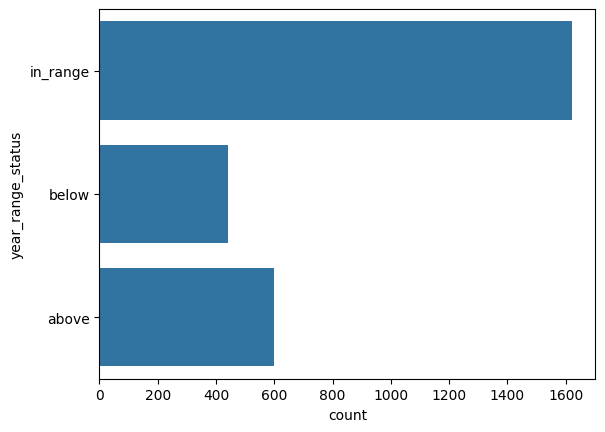

In [29]:
# Observación del porcentaje de cambio dentro del rango del maximo y minimo del año anterior, por encima del maximo, y por debajo del minimo.
sns.countplot(data=df["year_range_status"])
df.groupby(["year_range_status"]).agg(
    
    Numero_de_días = ("Change", "count"),
    Porcentaje_cambio_medio = ("Change", "mean"),
    Volatilidad_media = ("volatility","mean")
)

### Rango mensual.

,Numero_de_días,Porcentaje_cambio_medio,Volatilidad_media
monthly_range_status,,,
above,625,0.558096,1.645152
below,533,-0.790882,2.528068
in_range,1505,0.033389,2.038674


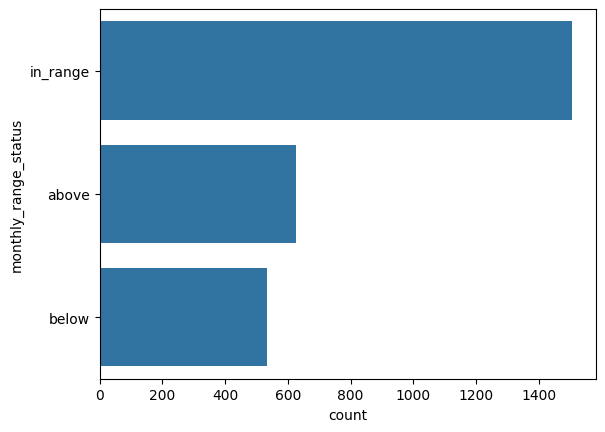

In [30]:
# Observación del porcentaje de cambio dentro del rango del maximo y minimo del mes anterior, por encima del maximo, y por debajo del minimo.
sns.countplot(data=df["monthly_range_status"])
df.groupby(["monthly_range_status"]).agg(
    
    Numero_de_días = ("Change", "count"),
    Porcentaje_cambio_medio = ("Change", "mean"),
    Volatilidad_media = ("volatility","mean")
)

### Rango semanal.

,Numero_de_días,Porcentaje_cambio_medio,Volatilidad_media
weekly_range_status,,,
above,607,1.320297,1.852059
below,503,-1.655884,2.265729
in_range,1553,0.005802,2.047969


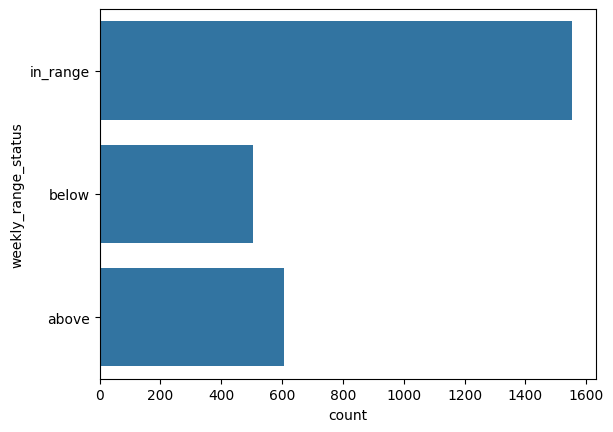

In [31]:
# Observación del porcentaje de cambio dentro del rango del maximo y minimo de la semana anterior, por encima del maximo, y por debajo del minimo.
sns.countplot(data=df["weekly_range_status"])
df.groupby(["weekly_range_status"]).agg(
    
    Numero_de_días = ("Change", "count"),
    Porcentaje_cambio_medio = ("Change", "mean"),
    Volatilidad_media = ("volatility","mean")
)

### Rango díario.

,Numero_de_días,Porcentaje_cambio_medio,Volatilidad_media
daily_range_status,,,
above,691,2.222084,2.056035
below,623,-2.686838,2.170129
in_range,1349,0.085960,1.980223


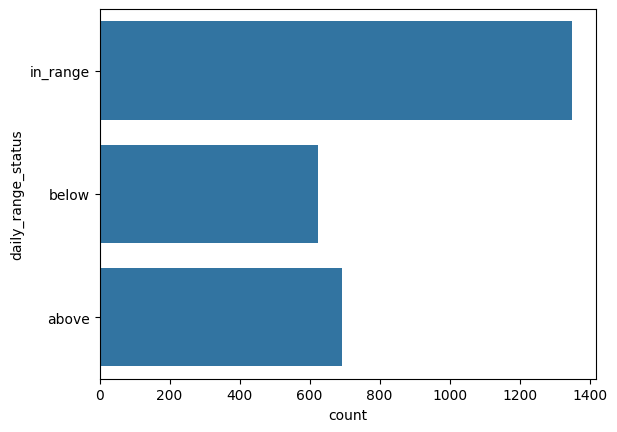

In [32]:
# Observación del porcentaje de cambio dentro del rango del maximo y minimo de la semana anterior, por encima del maximo, y por debajo del minimo.
sns.countplot(data=df["daily_range_status"])
df.groupby(["daily_range_status"]).agg(
    
    Numero_de_días = ("Change", "count"),
    Porcentaje_cambio_medio = ("Change", "mean"),
    Volatilidad_media = ("volatility","mean")
)


## Combinaciones de días en maximos mensuales, semanales y diarios.
- Cuantos días son los que cierran por encima de maximo mensual, semanal y diario.
- Cuales son las estadisticas de estos días: porcentaje medio, y sus desvicaciones estandar
- Graficar estos días para ver posibles patrones ya que son los dias que  que hay un brekout en zona no barrida.

### Análisis de cierre por encima del maximo anual, mensual, semanal y día anterior.

Estadísticas básicas de los días con cierre por encima del máximo anual, mensual, semanal y diario:
 count    56.000000
mean      1.856964
std       1.317565
min       0.080000
25%       1.115000
50%       1.640000
75%       2.350000
max       7.620000
Name: Change, dtype: float64


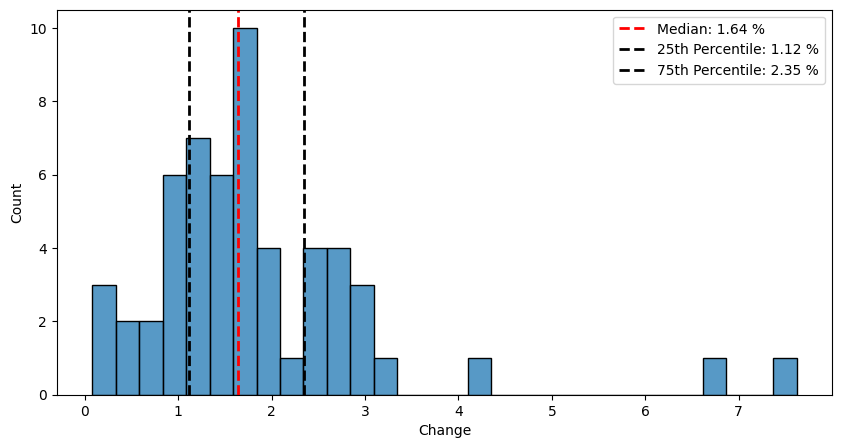

In [33]:
# Filtrar los datos para los días con cierre por encima del máximo anual, mensual, semanal y diario
above_year_month_week_daily = df[(df["weekly_range_status"] == "above") & 
                                 (df["daily_range_status"] == "above") &
                                 (df["monthly_range_status"] == "above") &
                                 (df["year_range_status"] == "above")]

print("Estadísticas básicas de los días con cierre por encima del máximo anual, mensual, semanal y diario:\n", 
      above_year_month_week_daily["Change"].describe())

# Preparar los datos para el gráfico
above_year_month_week_daily_plot = above_year_month_week_daily["Change"]
median_value = above_year_month_week_daily_plot.median()   # Mediana
q1_value = above_year_month_week_daily_plot.quantile(0.25)  # Primer cuartil (25%)
q3_value = above_year_month_week_daily_plot.quantile(0.75)  # Tercer cuartil (75%)

# Gráfico
plt.figure(figsize=(10,5))
sns.histplot(data=above_year_month_week_daily_plot, edgecolor='Black', bins=30)
plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f} %')
plt.axvline(q1_value, color='black', linestyle='--', linewidth=2, label=f'25th Percentile: {q1_value:.2f} %')
plt.axvline(q3_value, color='black', linestyle='--', linewidth=2, label=f'75th Percentile: {q3_value:.2f} %')
plt.legend()

### Análisis de cierre por debajo del del minimo anual, mensual, semanal y día anterior.

Estadísticas básicas de los días con cierre por debajo del mínimo anual, mensual, semanal y diario:
 count    51.000000
mean     -4.045097
std       3.571795
min     -24.390000
25%      -5.000000
50%      -3.770000
75%      -2.135000
max      -0.110000
Name: Change, dtype: float64


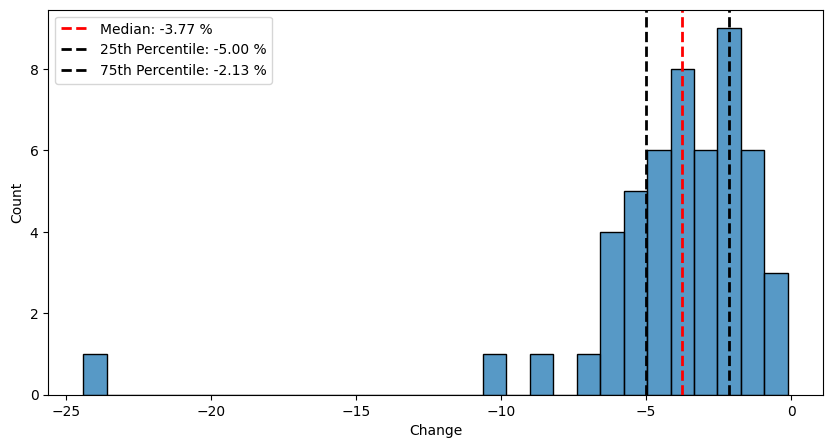

In [34]:
# Filtrar los datos para los días con cierre por debajo del mínimo anual, mensual, semanal y diario
below_year_month_week_daily = df[(df["weekly_range_status"] == "below") & 
                                 (df["daily_range_status"] == "below") &
                                 (df["monthly_range_status"] == "below") &
                                 (df["year_range_status"] == "below")]

print("Estadísticas básicas de los días con cierre por debajo del mínimo anual, mensual, semanal y diario:\n", 
      below_year_month_week_daily["Change"].describe())

# Preparar los datos para el gráfico
below_year_month_week_daily_plot = below_year_month_week_daily["Change"]
median_value = below_year_month_week_daily_plot.median()   # Mediana
q1_value = below_year_month_week_daily_plot.quantile(0.25)  # Primer cuartil (25%)
q3_value = below_year_month_week_daily_plot.quantile(0.75)  # Tercer cuartil (75%)

# Gráfico
plt.figure(figsize=(10,5))
sns.histplot(data=below_year_month_week_daily_plot, edgecolor='Black',bins = 30)
plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f} %')
plt.axvline(q1_value, color='black', linestyle='--', linewidth=2, label=f'25th Percentile: {q1_value:.2f} %')
plt.axvline(q3_value, color='black', linestyle='--', linewidth=2, label=f'75th Percentile: {q3_value:.2f} %')
plt.legend()

### Análisis de cierre por encima del maximo mensual, semanal y día anterior.

Estadísticas básicas de los días con cierre por encima del máximo mensual, semanal y diario:
 count    174.000000
mean       1.982586
std        1.371061
min        0.080000
25%        1.125000
50%        1.630000
75%        2.467500
max        7.750000
Name: Change, dtype: float64


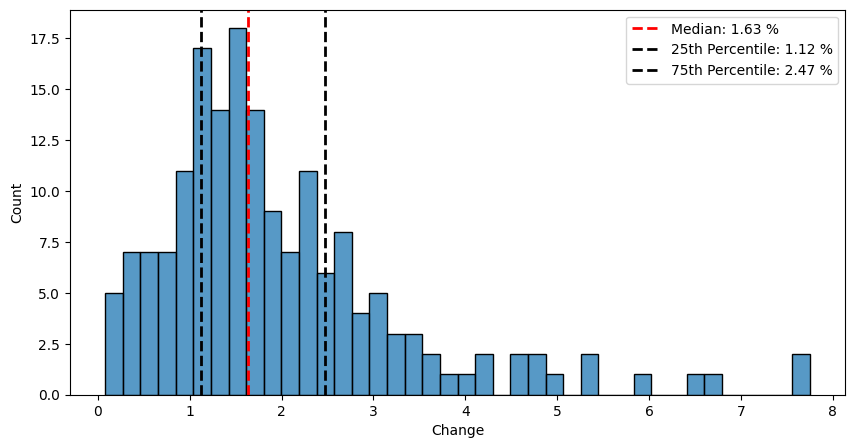

In [35]:
above_month_week_daily = df[(df["weekly_range_status"] == "above") & 
                            (df["daily_range_status"] == "above") &
                            (df["monthly_range_status"] == "above")]

print("Estadísticas básicas de los días con cierre por encima del máximo mensual, semanal y diario:\n", 
      above_month_week_daily["Change"].describe())

above_month_week_daily_plot = above_month_week_daily["Change"]
median_value = above_month_week_daily_plot.median()   # Mediana
q1_value = above_month_week_daily_plot.quantile(0.25)  # Primer cuartil (25%)
q3_value = above_month_week_daily_plot.quantile(0.75)  # Tercer cuartil (75%)

# Chart
plt.figure(figsize=(10,5))
sns.histplot(data=above_month_week_daily_plot, edgecolor='Black', bins=40)
plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f} %')
plt.axvline(q1_value, color='black', linestyle='--', linewidth=2, label=f'25th Percentile: {q1_value:.2f} %')
plt.axvline(q3_value, color='black', linestyle='--', linewidth=2, label=f'75th Percentile: {q3_value:.2f} %')
plt.legend()

### Análisis de cierre por debajo del minimo mensual, semanal y día anterior.

Estadisticas basicas de los días con cierre debajo del minimo mensual semanal y diario:
 count    152.000000
mean      -3.301381
std        2.735806
min      -24.390000
25%       -4.400000
50%       -2.525000
75%       -1.587500
max       -0.110000
Name: Change, dtype: float64


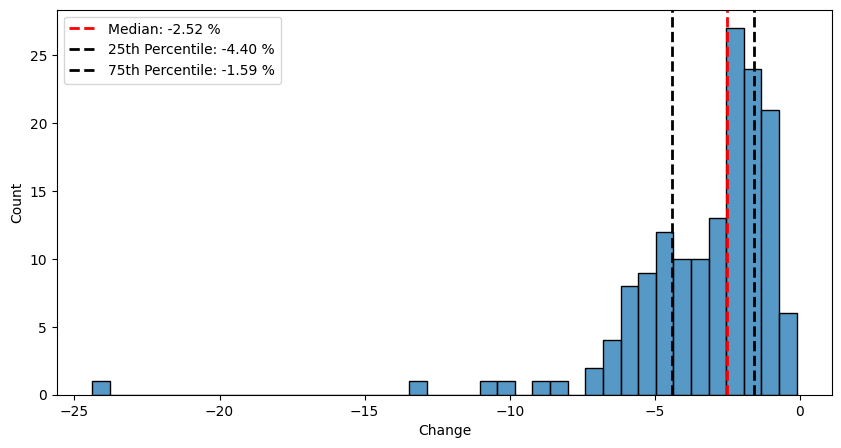

In [36]:
below_month_week_daily = below_week_daily = df[(df["weekly_range_status"] == "below") & 
                                               (df["daily_range_status"] == "below") &
                                               (df["monthly_range_status"] == "below")]
print("Estadisticas basicas de los días con cierre debajo del minimo mensual semanal y diario:\n",
      below_month_week_daily["Change"].describe())

below_month_week_daily_plot = below_month_week_daily["Change"]
median_value = below_month_week_daily_plot.median()   # Mediana
q1_value = below_month_week_daily_plot.quantile(0.25)  # Primer cuartil (25%)
q3_value = below_month_week_daily_plot.quantile(0.75)  # Tercer cuartil (75%)

# Chart
plt.figure(figsize=(10,5))
sns.histplot(data=below_month_week_daily_plot, edgecolor='Black',bins=40)
plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f} %')
plt.axvline(q1_value, color='black', linestyle='--', linewidth=2, label=f'25th Percentile: {q1_value:.2f} %')
plt.axvline(q3_value, color='black', linestyle='--', linewidth=2, label=f'75th Percentile: {q3_value:.2f} %')
plt.legend()

### Análisis de cierre por encima del maximo semanal y día anterior.

Estadisticas basicas de los días con cierre por encima del máximo semanal anterior y diario anterior:
 count    353.000000
mean       2.256431
std        2.242015
min        0.080000
25%        1.080000
50%        1.690000
75%        2.680000
max       20.460000
Name: Change, dtype: float64


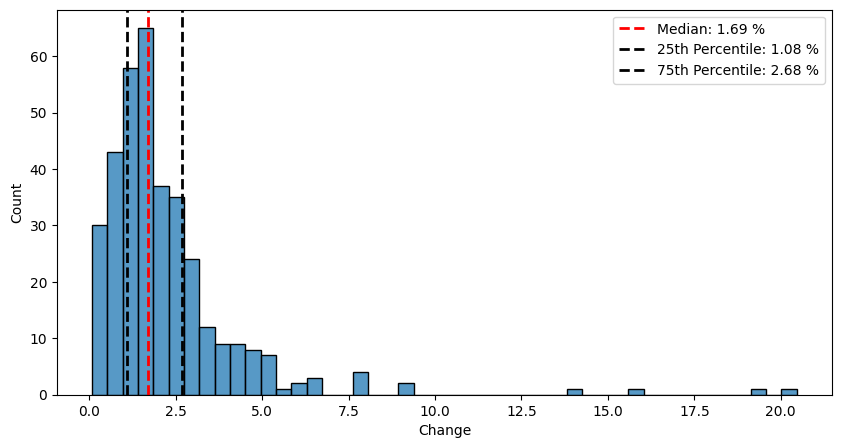

In [37]:
#Filtrado de variables con  cierres por encima semanal y diario.
above_week_daily = df[(df["weekly_range_status"] == "above") & (df["daily_range_status"] == "above")]
print("Estadisticas basicas de los días con cierre por encima del máximo semanal anterior y diario anterior:\n",above_week_daily["Change"].describe())

above_week_daily_plot = above_week_daily["Change"]
median_value = above_week_daily_plot.median()   # Mediana
q1_value = above_week_daily_plot.quantile(0.25)  # Primer cuartil (25%)
q3_value = above_week_daily_plot.quantile(0.75)  # Tercer cuartil (75%)

#Chart
plt.figure(figsize=(10,5))
sns.histplot(data=above_week_daily_plot, edgecolor='Black')
plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f} %')
plt.axvline(q1_value, color='black', linestyle='--', linewidth=2, label=f'25th Percentile: {q1_value:.2f} %')
plt.axvline(q3_value, color='black', linestyle='--', linewidth=2, label=f'75th Percentile: {q3_value:.2f} %')
plt.legend()

### Análisis de cierre por debajo del minimo semanal y día anterior.

Estadisticas basicas de los días con cierre debajo del minimo semanal anterior y diario anterior :
 count    309.000000
mean      -3.021133
std        2.280782
min      -24.390000
25%       -3.800000
50%       -2.610000
75%       -1.590000
max       -0.020000
Name: Change, dtype: float64


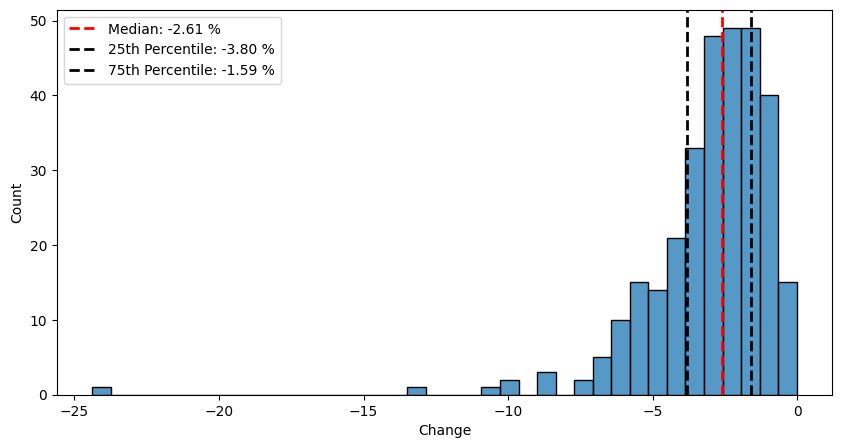

In [38]:
#Filtrado de variables con  cierres por debajo semanal y diario.
below_week_daily = df[(df["weekly_range_status"] == "below") & (df["daily_range_status"] == "below")]
print("Estadisticas basicas de los días con cierre debajo del minimo semanal anterior y diario anterior :\n",below_week_daily["Change"].describe())

below_week_daily_plot = below_week_daily["Change"]
median_value = below_week_daily_plot.median()   # Mediana
q1_value = below_week_daily_plot.quantile(0.25)  # Primer cuartil (25%)
q3_value = below_week_daily_plot.quantile(0.75)  # Tercer cuartil (75%)

#Chart
plt.figure(figsize=(10,5))
sns.histplot(data=below_week_daily_plot, edgecolor='Black')
plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f} %')
plt.axvline(q1_value, color='black', linestyle='--', linewidth=2, label=f'25th Percentile: {q1_value:.2f} %')
plt.axvline(q3_value, color='black', linestyle='--', linewidth=2, label=f'75th Percentile: {q3_value:.2f} %')
plt.legend()

# Análisis anual integral.

- Eventos Destacados Anuales
- Porcentaje de Rango Anual
- Porcentaje de Cambio Anual
- Volatilidad Anual
- Precio Medio Anual
- Correlación con S&P 500 y EUR/USD




In [39]:
# Diccionario con los eventos mas importantes de cada año.
eventos_importantes_anuales = {
    2014: "Caída de precios por exceso de oferta. OPEP no reduce producción.",
    2015: "Caída prolongada de precios. Reducción de inversiones en exploración y producción.",
    2016: "Acuerdo OPEP para reducir producción; precios suben a $50. Recuperación lenta del mercado.",
    2017: "Extensión de recortes OPEP+. Aumento de producción de esquisto en EE.UU.",
    2018: "EE.UU. se convierte en mayor productor. Tensiones comerciales con China afectan mercado.",
    2019: "Ataque a Aramco provoca alza de precios. Aumenta la presión por la transición energética.",
    2020: "COVID-19 desploma demanda y precios. OPEP+ acuerda recorte histórico.",
    2021: "Recuperación de precios. Mayor enfoque en energías renovables.",
    2022: "Guerra en Ucrania provoca volatilidad. Crisis energética en Europa.",
    2023: "OPEP+ ajusta producción. Inversión creciente en energías limpias.",
    2024: "Guerra Israel-Hamás, Elecciones USA"
}

# Creamos la variable y se la asignamos con clave valor utilizando .map y la variable "year" como clave.
df['annual_key_events'] = df['year'].map(eventos_importantes_anuales)
df.head(1)


,Date,Open,High,Low,Close,Volume,Close_eurusd,Close_sp500,Close_xle,Noticia_EIA,...,volatility,volume_change,bullish_bearish_day,bullish_bearish_before_day,bullish_bearish_next_day,daily_range_status,weekly_range_status,monthly_range_status,year_range_status,annual_key_events
0,2014-01-02,98.5,98.97,95.34,95.44,251248,1.3652,1826.5,87.25,NaN,...,NaN,NaN,bearish_day,None,bearish_day,in_range,in_range,in_range,in_range,Caída de precios por exceso de oferta. OPEP no...


#### Porcentaje del rango anual.
- Corrección de 2020 mes de abríl semana 17: Ajuste de valores atípicos por precios negativos del petróleo durante la crisis COVID-19.
- Método: Winsorización aplicando el primer y último decil
- Visualización con barplot.

In [40]:
#Calcular el porcentaje de cambio semanal (Rango entre maximo y minimo)
df['weekly_pct_diff'] = (df['weekly_max'] - df['weekly_min']) / df['weekly_min'] * 100

#Calcular el porcentaje de cambio mensual
df['monthly_pct_diff'] = (df['monthly_max'] - df['monthly_min']) / df['monthly_min'] * 100

#Calcular el porcentaje de cambio anual
df['anual_pct_diff'] = (df['year_max'] - df['year_min']) / df['year_min'] * 100

In [41]:
#Winsorización con filtro
df['anual_pct_diff'] = np.where(
    df['year'] == 2020,  # Condición: solo para el año 2020
    winsorize(df['anual_pct_diff'], limits=[0.1, 0.1]),  # Aplicar Winsorización
    df['anual_pct_diff']  # Mantener el resto de los valores sin cambios
)

# Imprime la media anual de 'anual_pct_diff' por año, ordenada por año.
year_anual = df.groupby("year")["anual_pct_diff"].mean().sort_index()
for year, stats in year_anual.items():
    print(f"Year: {year}, Anual_pct_diff: {stats:.2f} %")

Year: 2014, Anual_pct_diff: 100.99 %
Year: 2015, Anual_pct_diff: 84.17 %
Year: 2016, Anual_pct_diff: 109.25 %
Year: 2017, Anual_pct_diff: 43.90 %
Year: 2018, Anual_pct_diff: 81.54 %
Year: 2019, Anual_pct_diff: 50.17 %
Year: 2020, Anual_pct_diff: 26.54 %
Year: 2021, Anual_pct_diff: 81.03 %
Year: 2022, Anual_pct_diff: 84.70 %
Year: 2023, Anual_pct_diff: 49.32 %
Year: 2024, Anual_pct_diff: 26.54 %


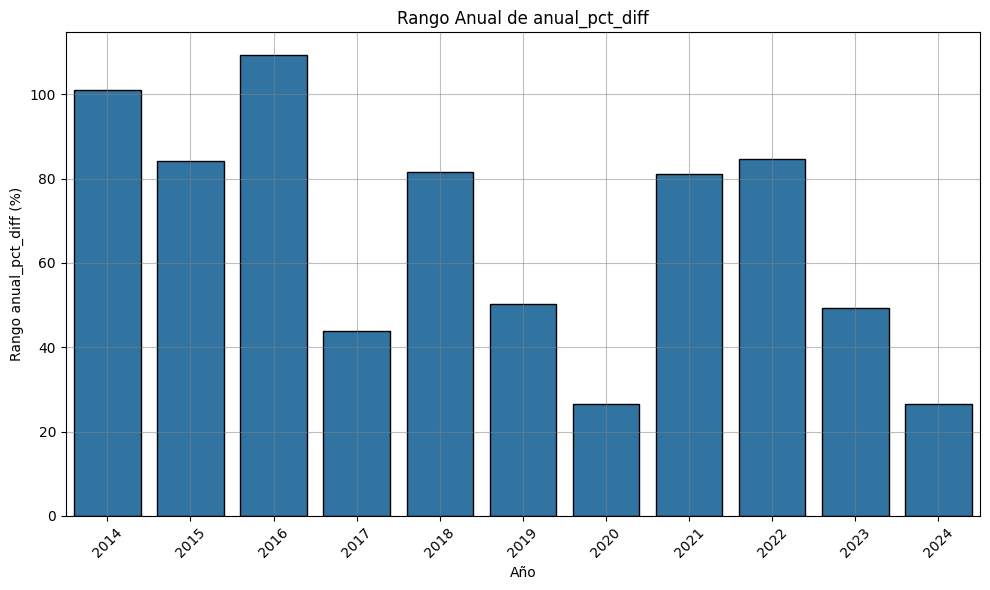

In [42]:
# Resetear el índice para poder graficar
year_anual_plot = year_anual.reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='anual_pct_diff', data=year_anual_plot, edgecolor='Black')

# Añadir etiquetas y título
plt.xlabel('Año')
plt.ylabel('Rango anual_pct_diff (%)')
plt.title('Rango Anual de anual_pct_diff')
plt.xticks(rotation=45)
plt.grid(color="Gray", alpha=0.5)
plt.tight_layout()
plt.show()

#### Porcentaje de cambio anual.

    year  pct_change_anual
0   2014        -44.436548
1   2015        -32.715713
2   2016         42.872340
3   2017         11.476015
4   2018        -24.700997
5   2019         36.488280
6   2020        -21.374170
7   2021         55.392562
8   2022          6.037786
9   2023        -11.071118
10  2024          8.645935


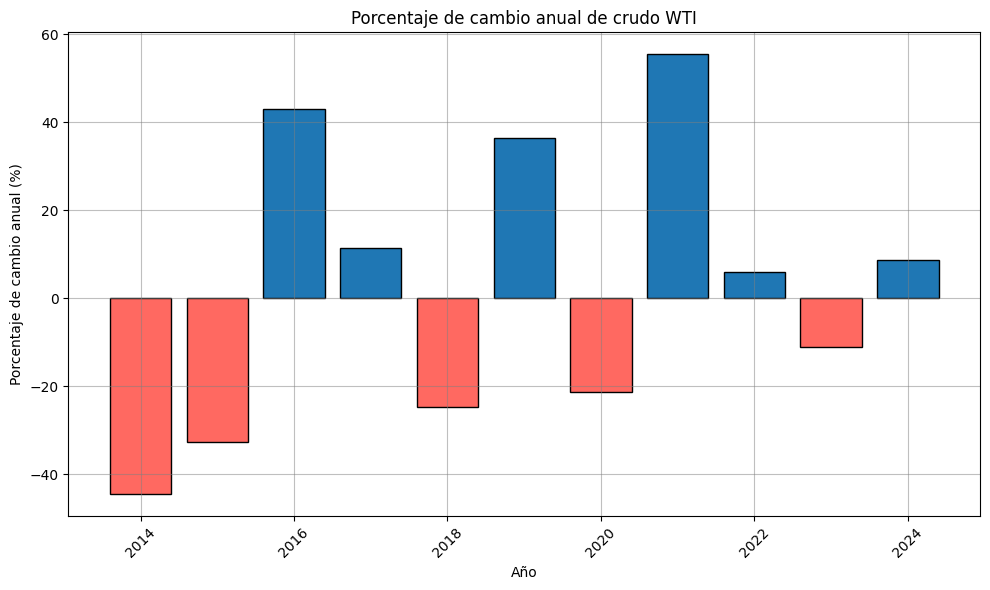

In [43]:
# Agrupar los datos por año y obtener el primer valor de 'Open' y el último valor de 'Close' para cada año
df_yearly = df.groupby('year').agg({'Open': 'first', 'Close': 'last'}).reset_index()

# Calcular el porcentaje de cambio entre el 'Open' del primer día y el 'Close' del último día de cada año
df_yearly['pct_change_anual'] = (df_yearly['Close'] / df_yearly['Open'] - 1) * 100

# Mostrar las columnas 'year' y 'pct_change_anual'
print(df_yearly[['year', 'pct_change_anual']])

#Variable para color del chart
colors = np.where(df_yearly['pct_change_anual'] > 0, '#1f77b4', '#FF6961')

#Chart
plt.figure(figsize=(10, 6))
plt.bar(df_yearly['year'], df_yearly['pct_change_anual'], color=colors, edgecolor='black')
plt.xlabel('Año')
plt.ylabel('Porcentaje de cambio anual (%)')
plt.title('Porcentaje de cambio anual de crudo WTI')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor visibilidad
plt.tight_layout()
plt.grid(color="Gray", alpha=0.5)
plt.show()

#### Volatilidad anual.

    year  volatility
0   2014    1.193388
1   2015    2.551922
2   2016    2.404680
3   2017    1.410359
4   2018    1.588805
5   2019    1.690120
6   2020    3.422275
7   2021    1.910595
8   2022    2.710278
9   2023    1.910319
10  2024    1.354795


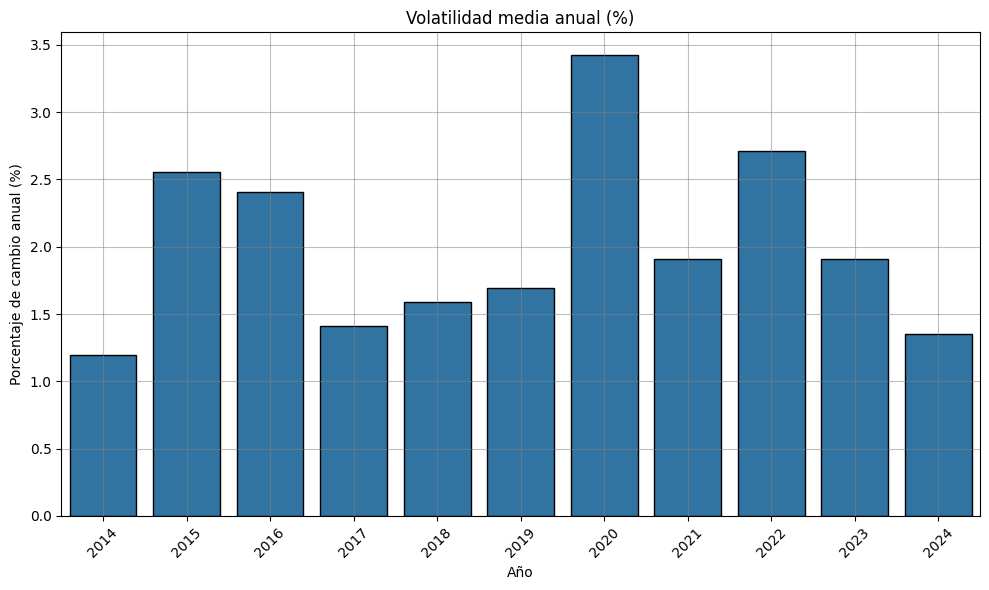

In [44]:
# Agrupar los datos por año, seleccionando la primera apertura del año, el último cierre y la volatilidad media anual
volatility_yearly = df.groupby('year').agg({'Open': 'first', 'Close': 'last', 'volatility': 'mean'}).reset_index()
print(volatility_yearly[["year","volatility"]])

#Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=volatility_yearly, x="year", y="volatility",edgecolor="black")
plt.xlabel('Año')
plt.ylabel('Porcentaje de cambio anual (%)')
plt.title('Volatilidad media anual (%)')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.grid(color="Gray", alpha=0.5)
plt.show()

    year     Volume
0   2014  256650.53
1   2015  379511.76
2   2016  557903.81
3   2017  623069.76
4   2018  619355.73
5   2019  616724.91
6   2020  468212.64
7   2021  407397.05
8   2022  322579.35
9   2023  313548.75
10  2024  310835.36


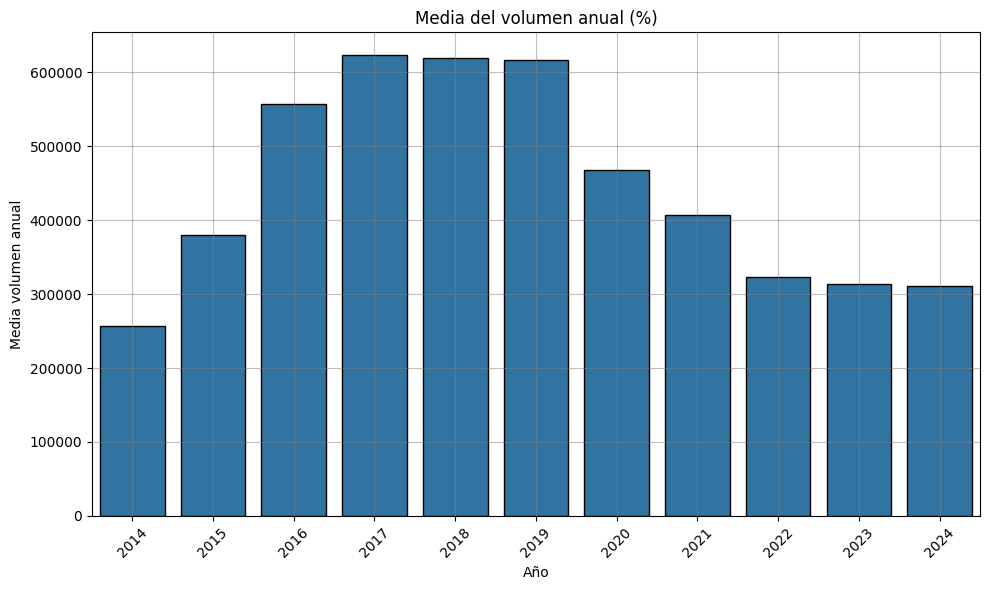

In [45]:
# Agrupar los datos por año, seleccionando la primera apertura del año, el último cierre y el volumen medio anual
volume_yearly = df.groupby('year').agg({'Open': 'first', 'Close': 'last', 'Volume': 'mean'}).reset_index()
volume_yearly["Volume"] = volume_yearly["Volume"].round(2)

print(volume_yearly[["year","Volume"]])

#Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=volume_yearly, x="year", y="Volume",edgecolor="black")
plt.xlabel('Año')
plt.ylabel('Media volumen anual')
plt.title('Media del volumen anual (%)')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.grid(color="Gray", alpha=0.5)
plt.show()

#### Precio promedio anual.

    year  Close
0   2014  93.37
1   2015  48.82
2   2016  43.45
3   2017  50.85
4   2018  65.04
5   2019  56.96
6   2020  39.52
7   2021  68.10
8   2022  94.38
9   2023  77.59
10  2024  79.07


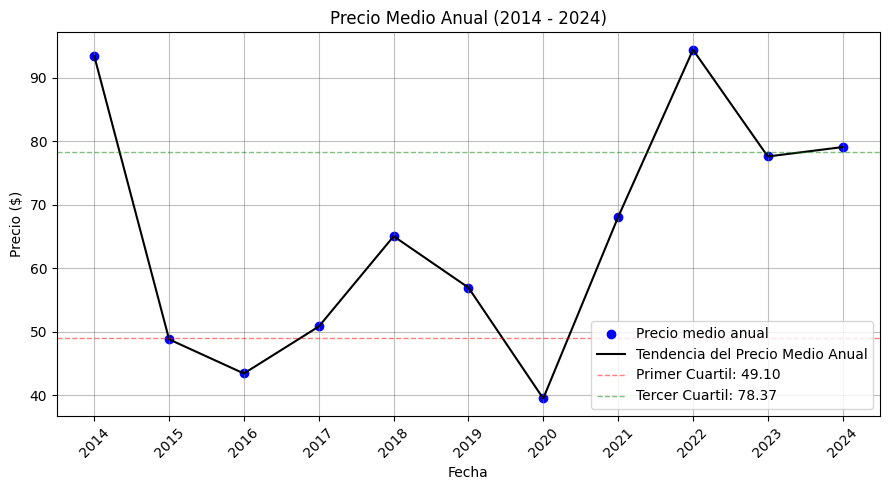

In [46]:
#Calcular el precio promedio anual.
precio_medio_anual = df.groupby("year")["Close"].mean().reset_index()
precio_medio_anual['Close'] = precio_medio_anual['Close'].round(2)  
print(precio_medio_anual)

import matplotlib.pyplot as plt

# Calcular el rango intercuartil
primer_cuartil = df['Close'].quantile(0.25)
tercer_cuartil = df['Close'].quantile(0.75)

# Chart
plt.figure(figsize=(9, 5))
plt.scatter(pd.to_datetime(precio_medio_anual['year'], format='%Y'), precio_medio_anual['Close'], color='b', label='Precio medio anual')
plt.plot(pd.to_datetime(precio_medio_anual['year'], format='%Y'), precio_medio_anual['Close'], linestyle='-', color='black', label='Tendencia del Precio Medio Anual')
plt.axhline(y=primer_cuartil, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Primer Cuartil: {primer_cuartil:.2f}')
plt.axhline(y=tercer_cuartil, color='green', linestyle='--', linewidth=1, alpha=0.5, label=f'Tercer Cuartil: {tercer_cuartil:.2f}')
plt.xlabel('Fecha')
plt.ylabel('Precio ($)')
plt.title('Precio Medio Anual (2014 - 2024)')
plt.legend(loc='lower right')
plt.grid(True, color="Gray", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Correlación con SP500, EURUSD, XLE.

                 Close  Close_eurusd  Close_sp500  Close_xle
Close         1.000000      0.221497     0.392499   0.681093
Close_eurusd  0.221497      1.000000    -0.377676   0.050323
Close_sp500   0.392499     -0.377676     1.000000   0.035066
Close_xle     0.681093      0.050323     0.035066   1.000000


<Axes: >

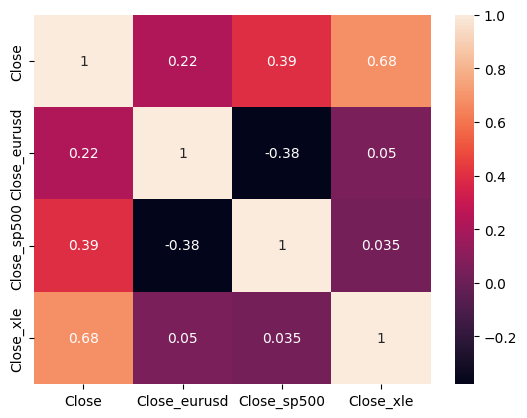

In [47]:
# Calcular la correlación de Pearson entre petróleo, eurodólar, S&P 500 y DXY
correlacion = df[['Close', 'Close_eurusd', 'Close_sp500',"Close_xle"]].corr("pearson")
print(correlacion)

#Chart
sns.heatmap(correlacion, annot=True)

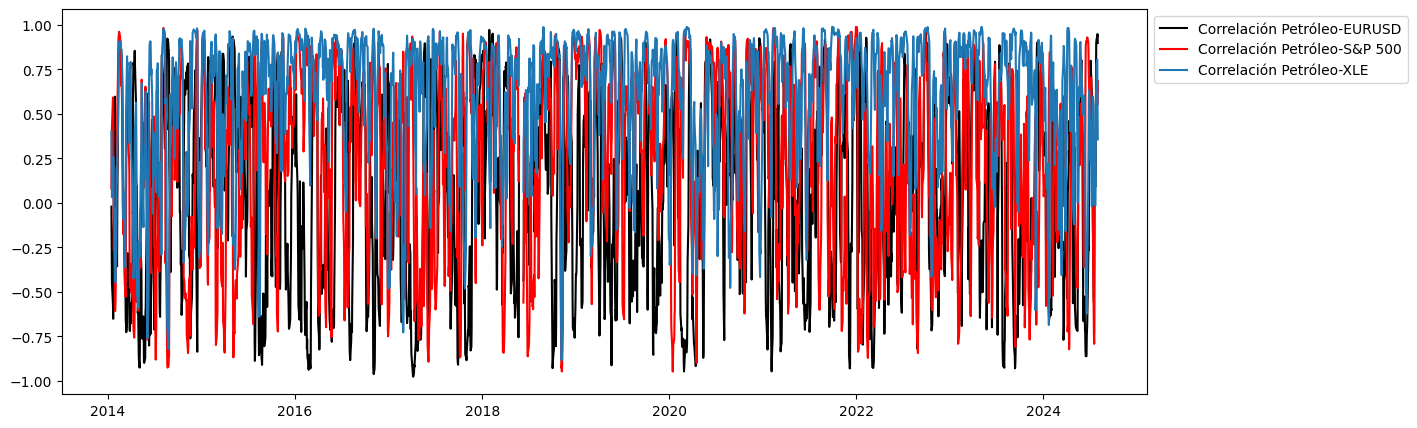

In [48]:
# Calcular correlaciones móviles de 10 días
window_size = 10
df['corr_oil_eurusd'] = df['Close'].rolling(window=window_size).corr(df['Close_eurusd'])
df['corr_oil_sp500'] = df['Close'].rolling(window=window_size).corr(df['Close_sp500'])
df['corr_oil_xle'] = df['Close'].rolling(window=window_size).corr(df['Close_xle'])


#Chart
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['corr_oil_eurusd'], label='Correlación Petróleo-EURUSD',color= "Black")
plt.plot(df['Date'], df['corr_oil_sp500'], label='Correlación Petróleo-S&P 500',color= "red")
plt.plot(df['Date'], df['corr_oil_xle'], label='Correlación Petróleo-XLE')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

- -------------------------------------------------------------------------

In [49]:
correlacion = df[['Close', 'Close_eurusd', 'Close_sp500',"Close_xle","inventario_final_semanal", "exportacion_diaria_promedio","volatility"]].corr("pearson")
correlacion


,Close,Close_eurusd,Close_sp500,Close_xle,inventario_final_semanal,exportacion_diaria_promedio,volatility
Close,1.000000,0.221497,0.392499,0.681093,-0.645505,0.247939,-0.294772
Close_eurusd,0.221497,1.000000,-0.377676,0.050323,-0.506434,-0.465895,-0.262699
Close_sp500,0.392499,-0.377676,1.000000,0.035066,0.127547,0.837529,-0.035032
Close_xle,0.681093,0.050323,0.035066,1.000000,-0.562097,-0.052522,-0.325823
inventario_final_semanal,-0.645505,-0.506434,0.127547,-0.562097,1.000000,0.757968,0.165494
exportacion_diaria_promedio,0.247939,-0.465895,0.837529,-0.052522,0.757968,1.000000,0.061452
volatility,-0.294772,-0.262699,-0.035032,-0.325823,0.165494,0.061452,1.000000


### Análisis Mensual.

In [50]:
# Winsorización con filtro: solo para abril de 2020
df['monthly_pct_diff'] = np.where(
    (df['year'] == 2020) & (df['month_name'] == "April"),  # Condición: abril de 2020
    winsorize(df['monthly_pct_diff'], limits=[0.1, 0.1]),  # Aplicar Winsorización
    df['monthly_pct_diff']  # Mantener el resto de los valores sin cambios
)
# Imprime el rango entre max y min mensual para cada mes.
month_anual = df.groupby("month_name")["monthly_pct_diff"].mean().sort_values()
for month, stats in month_anual.items():
    print(f"Month: {month}, monthly_pct_diff: {stats:.2f} %")

Month: September, monthly_pct_diff: 14.35 %
Month: June, monthly_pct_diff: 14.73 %
Month: April, monthly_pct_diff: 14.78 %
Month: August, monthly_pct_diff: 15.10 %
Month: October, monthly_pct_diff: 15.44 %
Month: July, monthly_pct_diff: 16.07 %
Month: February, monthly_pct_diff: 16.32 %
Month: January, monthly_pct_diff: 19.62 %
Month: May, monthly_pct_diff: 21.40 %
Month: November, monthly_pct_diff: 22.85 %
Month: December, monthly_pct_diff: 28.86 %
Month: March, monthly_pct_diff: 31.41 %


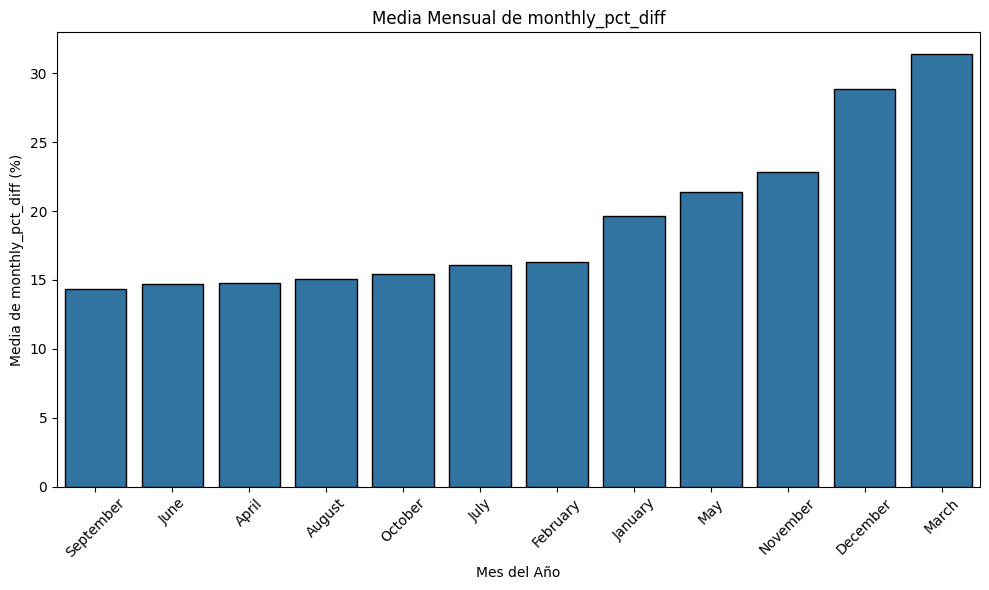

In [51]:
#Reseteamos el index para poder graficar
monthly_anual_plot = month_anual.reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='month_name', y='monthly_pct_diff', data=monthly_anual_plot, edgecolor='Black')
plt.xlabel('Mes del Año')
plt.ylabel('Media de monthly_pct_diff (%)')
plt.title('Media Mensual de monthly_pct_diff')
plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

### Análisis Semanal.

In [52]:
# Winsorización con filtro: solo para la semana 17 de abril de 2020.
df['weekly_pct_diff'] = np.where(
    (df['year'] == 2020) & (df['month_name'] == "April") & (df['week'] == 17),  # Condición: abril de 2020 semana numero 17 (Semana del crash)
    winsorize(df['weekly_pct_diff'], limits=[0.1, 0.1]),  # Aplicar Winsorización
    df['weekly_pct_diff']  # Mantener el resto de los valores sin cambios
)

# Imprime el rango entre max y min semanal para cada semana del año.
weekly_anual = df.groupby("week")["weekly_pct_diff"].mean()
for week, stats in weekly_anual.items():
    print(f"Week: {week}, weekly_pct_diff: {stats:.2f} %")

Week: 1, weekly_pct_diff: 9.37 %
Week: 2, weekly_pct_diff: 8.57 %
Week: 3, weekly_pct_diff: 7.67 %
Week: 4, weekly_pct_diff: 7.36 %
Week: 5, weekly_pct_diff: 8.52 %
Week: 6, weekly_pct_diff: 9.46 %
Week: 7, weekly_pct_diff: 6.87 %
Week: 8, weekly_pct_diff: 7.58 %
Week: 9, weekly_pct_diff: 9.71 %
Week: 10, weekly_pct_diff: 9.64 %
Week: 11, weekly_pct_diff: 12.52 %
Week: 12, weekly_pct_diff: 13.59 %
Week: 13, weekly_pct_diff: 9.47 %
Week: 14, weekly_pct_diff: 11.20 %
Week: 15, weekly_pct_diff: 8.38 %
Week: 16, weekly_pct_diff: 11.26 %
Week: 17, weekly_pct_diff: 6.53 %
Week: 18, weekly_pct_diff: 17.22 %
Week: 19, weekly_pct_diff: 10.21 %
Week: 20, weekly_pct_diff: 7.61 %
Week: 21, weekly_pct_diff: 7.62 %
Week: 22, weekly_pct_diff: 7.44 %
Week: 23, weekly_pct_diff: 6.85 %
Week: 24, weekly_pct_diff: 7.88 %
Week: 25, weekly_pct_diff: 8.23 %
Week: 26, weekly_pct_diff: 7.03 %
Week: 27, weekly_pct_diff: 7.52 %
Week: 28, weekly_pct_diff: 7.28 %
Week: 29, weekly_pct_diff: 6.88 %
Week: 30, weekly_

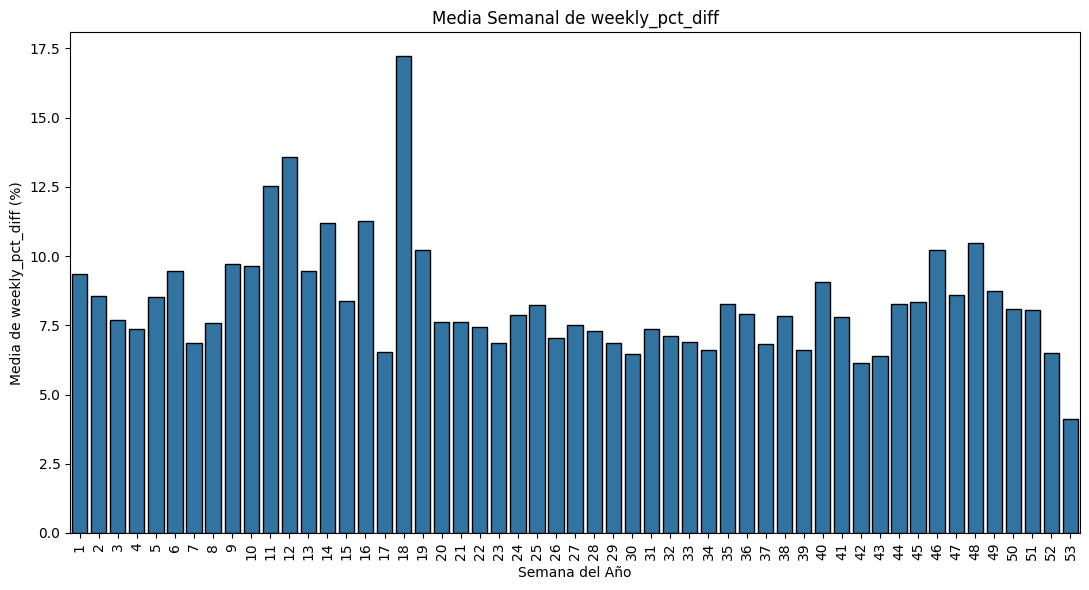

In [82]:
#Reseteamos el index para poder graficar
weekly_anual_plot = weekly_anual.reset_index()

plt.figure(figsize=(11, 6))
sns.barplot(x='week', y='weekly_pct_diff',data=weekly_anual_plot,edgecolor="Black" )

# Añadir etiquetas y título
plt.xlabel('Semana del Año')
plt.ylabel('Media de weekly_pct_diff (%)')
plt.title('Media Semanal de weekly_pct_diff')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Análisis macro de inventario crudo.
- Modelado de la estructura del dataset de datos macro del crudo.
- Producción díaria.
- Importacion promedio diaria.
- Exportacio promedio diaria
- Inventario semanal.

In [54]:
#Rellenamos todos los valores de la semana con  ffil  (relleno hacia adelante), que copiaría el valor del viernes en los días anteriores de la semana.
df['produccion_diaria_promedio'] = df['produccion_diaria_promedio'].ffill()
df['importacion_diaria_promedio'] = df['importacion_diaria_promedio'].ffill()
df['exportacion_diaria_promedio'] = df['exportacion_diaria_promedio'].ffill()

<Axes: >

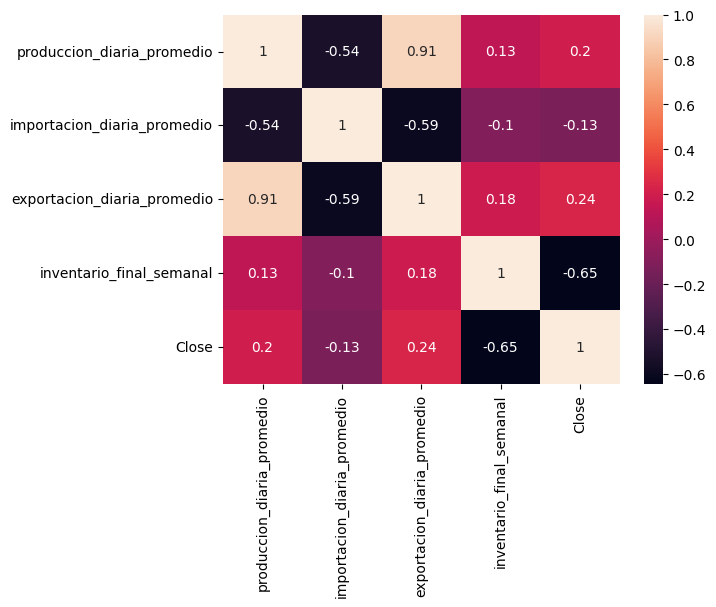

In [55]:
correlacion = df[['produccion_diaria_promedio', 'importacion_diaria_promedio', 'exportacion_diaria_promedio', 'inventario_final_semanal',"Close"]].corr("pearson")
sns.heatmap(correlacion, annot=True)

In [56]:
# Calcular el porcentaje de cambio para cada variable
df['produccion_pct_change'] = df['produccion_diaria_promedio'].pct_change() 
df['importacion_pct_change'] = df['importacion_diaria_promedio'].pct_change() 
df['exportacion_pct_change'] = df['exportacion_diaria_promedio'].pct_change() 
df['inventario_pct_change'] = df['inventario_final_semanal'].pct_change() 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15468\719177759.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['inventario_pct_change'] = df['inventario_final_semanal'].pct_change()


## Análisis de la producción díaria.
- Porcentaje acumulativo.
- Producción diaria promedio.
- Cambio porcentual en producción díaria
- Rachas semanales positivas y negativas de produccion.
- Relación entre las rachas de aumento y disminución de producción y otras variables como porcentaje de cambio y noticias macro.

In [57]:
# Calcular el cambio porcentual acumulativo para la producción
df['produccion_cambio_acumulativo'] = (1 + df['produccion_pct_change'] / 100).cumprod() - 1

# Multiplicamos por 100 para expresar el resultado como porcentaje
df['produccion_cambio_acumulativo'] = df['produccion_cambio_acumulativo'] * 100

# Calcular los percentiles
percentil_3 = df["produccion_pct_change"].quantile(0.035)
percentil_96 = df["produccion_pct_change"].quantile(0.965)

df['produccion_diaria_promedio'].describe()

count     2662.000000
mean     10755.931255
std       1570.721120
min       8044.000000
25%       9214.000000
50%      11000.000000
75%      12100.000000
max      13300.000000
Name: produccion_diaria_promedio, dtype: float64

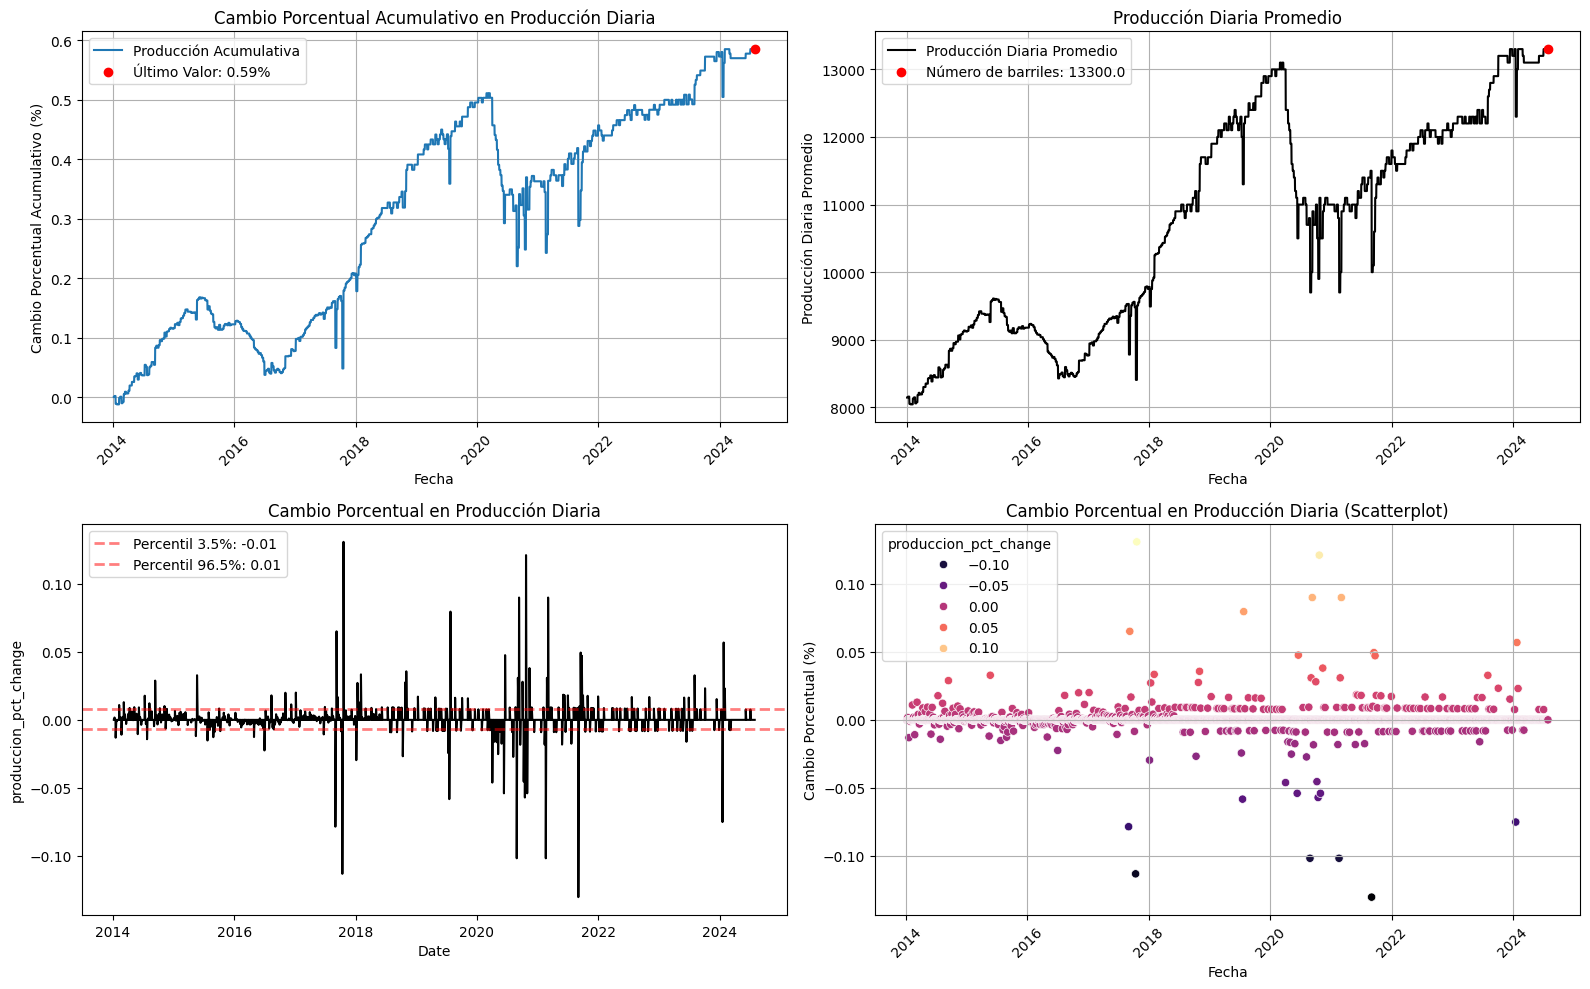

In [58]:
# Crear una figura con 4 subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Primer gráfico: Cambio porcentual acumulativo en la primera fila, primer gráfico
sns.lineplot(data=df, x='Date', y='produccion_cambio_acumulativo', label='Producción Acumulativa', ax=axs[0, 0])
ultimo_valor_acumulativo = df['produccion_cambio_acumulativo'].iloc[-1]
ultima_fecha_acumulativo = df['Date'].iloc[-1]
ultimo_valor_acumulativo_str = f"Último Valor: {ultimo_valor_acumulativo:.2f}%"
axs[0, 0].scatter(ultima_fecha_acumulativo, ultimo_valor_acumulativo, color='red', label=ultimo_valor_acumulativo_str, zorder=5)
axs[0, 0].legend(loc='upper left')
axs[0, 0].set_title('Cambio Porcentual Acumulativo en Producción Diaria')
axs[0, 0].set_ylabel('Cambio Porcentual Acumulativo (%)')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].grid(True)

# Segundo gráfico: Producción diaria promedio en la primera fila, segundo gráfico
sns.lineplot(data=df, x='Date', y='produccion_diaria_promedio', color="black", label='Producción Diaria Promedio', ax=axs[0, 1])
ultimo_valor_produccion = df['produccion_diaria_promedio'].iloc[-1]
ultima_fecha_produccion = df['Date'].iloc[-1]
ultimo_valor_produccion_str = f"Número de barriles: {ultimo_valor_produccion}"
axs[0, 1].scatter(ultima_fecha_produccion, ultimo_valor_produccion, color='red', label=ultimo_valor_produccion_str, zorder=5)
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title('Producción Diaria Promedio')
axs[0, 1].set_ylabel('Producción Diaria Promedio')
axs[0, 1].set_xlabel('Fecha')
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].grid(True)

# Tercer gráfico: Línea de cambio porcentual con percentiles, segunda fila, primer gráfico
sns.lineplot(data=df, x="Date", y="produccion_pct_change", color="black", ax=axs[1, 0])
axs[1, 0].axhline(y=percentil_3, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Percentil 3.5%: {percentil_3:.2f}')
axs[1, 0].axhline(y=percentil_96, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Percentil 96.5%: {percentil_96:.2f}')
axs[1, 0].set_title('Cambio Porcentual en Producción Diaria')
axs[1, 0].legend(loc='upper left')

# Cuarto gráfico: Scatterplot con la paleta "magma", segunda fila, segundo gráfico
sns.scatterplot(data=df, x='Date', y='produccion_pct_change', hue="produccion_pct_change", palette="magma", ax=axs[1, 1])
axs[1, 1].set_title('Cambio Porcentual en Producción Diaria (Scatterplot)')
axs[1, 1].set_ylabel('Cambio Porcentual (%)')
axs[1, 1].set_xlabel('Fecha')
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [59]:
# Agrupar los datos por semana y año, obteniendo la media de producción diaria por semana
df_semanal = df.groupby(['year', 'week']).agg(
    produccion_semanal=('produccion_diaria_promedio', 'mean'),
    fecha_inicio=('Date', 'min'),  # Fecha de inicio de la semana
    fecha_fin=('Date', 'max')  # Fecha de fin de la semana
).reset_index()

# Calcular la diferencia semanal en la producción
df_semanal['produccion_diff'] = df_semanal['produccion_semanal'].diff()

# Identificar rachas de crecimiento (+1) o disminución (-1) por semana
df_semanal['racha'] = np.sign(df_semanal['produccion_diff'])

# Identificar rachas consecutivas semanales
df_semanal['racha_id'] = (df_semanal['racha'] != df_semanal['racha'].shift(1)).cumsum()

# Agrupar por racha_id, capturando la producción inicial y final
rachas_semanales = df_semanal.groupby('racha_id').agg(
    racha_tipo=('racha', 'first'),  # Tipo de racha: crecimiento o disminución
    duracion=('racha', 'count'),    # Duración de la racha semanal
    fecha_inicio=('fecha_inicio', 'first'),  # Fecha de inicio de la racha
    fecha_fin=('fecha_fin', 'last'),  # Fecha de fin de la racha
    produccion_inicio=('produccion_semanal', 'first'),  # Producción al inicio de la racha
    produccion_fin=('produccion_semanal', 'last')  # Producción al final de la racha
).reset_index()

# Calcular el cambio en barriles y el porcentaje de cambio
rachas_semanales['cambio_barriles'] = rachas_semanales['produccion_fin'] - rachas_semanales['produccion_inicio']
rachas_semanales['cambio_pct'] = (rachas_semanales['cambio_barriles'] / rachas_semanales['produccion_inicio']) * 100

rachas_semanales["cambio_pct"] = rachas_semanales["cambio_pct"].round(2)
# Mostrar las rachas más largas
top_rachas_semanales = rachas_semanales.sort_values(by="duracion", ascending=False)
top_5_positivas = top_rachas_semanales[top_rachas_semanales["racha_tipo"] == 1.0].head(10)
top_5_negativas = top_rachas_semanales[top_rachas_semanales["racha_tipo"] == -1.0].head(10)

In [60]:
# Lista de pares de fechas de inicio y fin
fechas_inicio_fin = [
    ('2018-01-16', '2018-06-15'),
    ('2016-01-25', '2016-06-03'),
    ('2017-02-06', '2017-05-12'),
    ('2020-03-23', '2020-06-19'),
    ('2024-03-18', '2024-05-31')
]
# Recorrer la lista de fechas para calcular el porcentaje de cambio para cada par
for fecha_inicio, fecha_fin in fechas_inicio_fin:
    # Filtrar los valores de 'Close' para las fechas específicas
    valor_inicial = df.loc[df['Date'] == fecha_inicio, 'Close'].values[0]
    valor_final = df.loc[df['Date'] == fecha_fin, 'Close'].values[0]
    
    # Calcular el porcentaje de cambio
    porcentaje_cambio = ((valor_final - valor_inicial) / valor_inicial) * 100
    
    # Mostrar el resultado
    print(f"El porcentaje de cambio del CL entre {fecha_inicio} y {fecha_fin} es: {porcentaje_cambio:.2f}%")

top_rachas_semanales.head()


#Buscar rango de fechas para investigar
# df.loc[(df['Date'] >= '2017-02-06') & (df['Date'] <= '2017-05-12')]

El porcentaje de cambio del CL entre 2018-01-16 y 2018-06-15 es: 2.09%
El porcentaje de cambio del CL entre 2016-01-25 y 2016-06-03 es: 60.25%
El porcentaje de cambio del CL entre 2017-02-06 y 2017-05-12 es: -9.75%
El porcentaje de cambio del CL entre 2020-03-23 y 2020-06-19 es: 70.16%
El porcentaje de cambio del CL entre 2024-03-18 y 2024-05-31 es: -6.93%


,racha_id,racha_tipo,duracion,fecha_inicio,fecha_fin,produccion_inicio,produccion_fin,cambio_barriles,cambio_pct
75,76,1.0,22,2018-01-16,2018-06-15,9782.0,10900.0,1118.0,11.43
46,47,-1.0,19,2016-01-25,2016-06-03,9219.6,8737.5,-482.1,-5.23
61,62,1.0,14,2017-02-06,2017-05-12,8977.8,9312.2,334.4,3.72
122,123,-1.0,13,2020-03-23,2020-06-19,13000.0,10600.0,-2400.0,-18.46
213,214,0.0,11,2024-03-18,2024-05-31,13100.0,13100.0,0.0,0.00


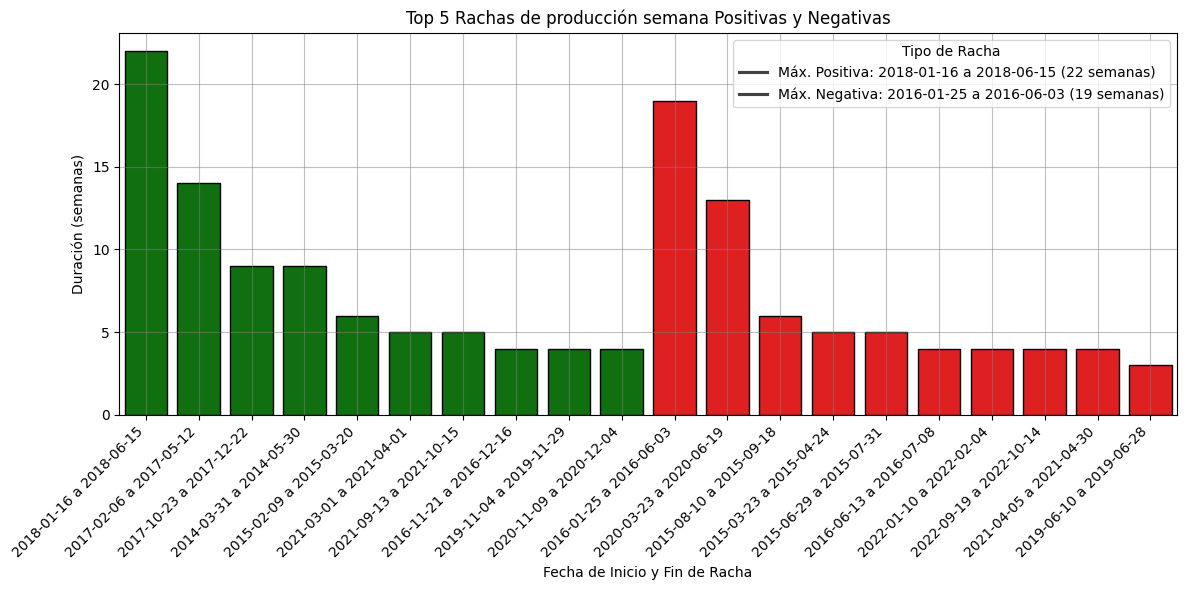

In [61]:
racha_max_positiva = top_5_positivas.loc[top_5_positivas['duracion'].idxmax()]
racha_max_negativa = top_5_negativas.loc[top_5_negativas['duracion'].idxmax()]

# Concatenar las 5 mejores rachas positivas y negativas
top_5_rachas = pd.concat([top_5_positivas, top_5_negativas])

# Crear una nueva columna que combine la fecha de inicio y fin como etiquetas
top_5_rachas['fecha_racha'] = top_5_rachas['fecha_inicio'].dt.strftime('%Y-%m-%d') + ' a ' + top_5_rachas['fecha_fin'].dt.strftime('%Y-%m-%d')

# Crear un gráfico de barras usando las fechas como etiquetas en el eje x
plt.figure(figsize=(12, 6))
sns.barplot(data=top_5_rachas, x='fecha_racha', y='duracion',edgecolor="Black", hue='racha_tipo', palette=['red', 'green'])

# Añadir títulos y etiquetas
plt.title('Top 5 Rachas de producción semana Positivas y Negativas')
plt.xlabel('Fecha de Inicio y Fin de Racha')
plt.ylabel('Duración (semanas)')

#Variables para fechas eje "X"
max_positiva_text = f"Máx. Positiva: {racha_max_positiva['fecha_inicio'].strftime('%Y-%m-%d')} a {racha_max_positiva['fecha_fin'].strftime('%Y-%m-%d')} ({racha_max_positiva['duracion']} semanas)"
max_negativa_text = f"Máx. Negativa: {racha_max_negativa['fecha_inicio'].strftime('%Y-%m-%d')} a {racha_max_negativa['fecha_fin'].strftime('%Y-%m-%d')} ({racha_max_negativa['duracion']} semanas)"
plt.legend(title='Tipo de Racha', loc='upper right', labels=[max_positiva_text, max_negativa_text])
plt.grid(alpha=0.5, color="gray")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- --------------------------------------------------------

## Análisis de la importación.
- Porcentaje acumulativo.
- importación diaria promedio.
- Cambio porcentual de la importación media díaria
- Rachas semanales positivas y negativas de importación.
- Relación entre las rachas de aumento y disminución de la importación y otras variables como porcentaje de cambio y noticias macro.

In [62]:
# Calcular el cambio porcentual acumulativo para la importación
df['importacion_cambio_acumulativo'] = (1 + df['importacion_pct_change'] / 100).cumprod() - 1

# Multiplicamos por 100 para expresar el resultado como porcentaje
df['importacion_cambio_acumulativo'] = df['importacion_cambio_acumulativo'] * 100

# Calcular los percentiles para importacion_pct_change
percentil_3_importacion = df["importacion_pct_change"].quantile(0.03)
percentil_96_importacion = df["importacion_pct_change"].quantile(0.97)

# Descripción estadística de la importación diaria promedio
df['importacion_diaria_promedio'].describe()


count    2662.000000
mean     6979.396694
std       875.640903
min      4599.000000
25%      6300.000000
50%      7037.000000
75%      7611.750000
max      9372.000000
Name: importacion_diaria_promedio, dtype: float64

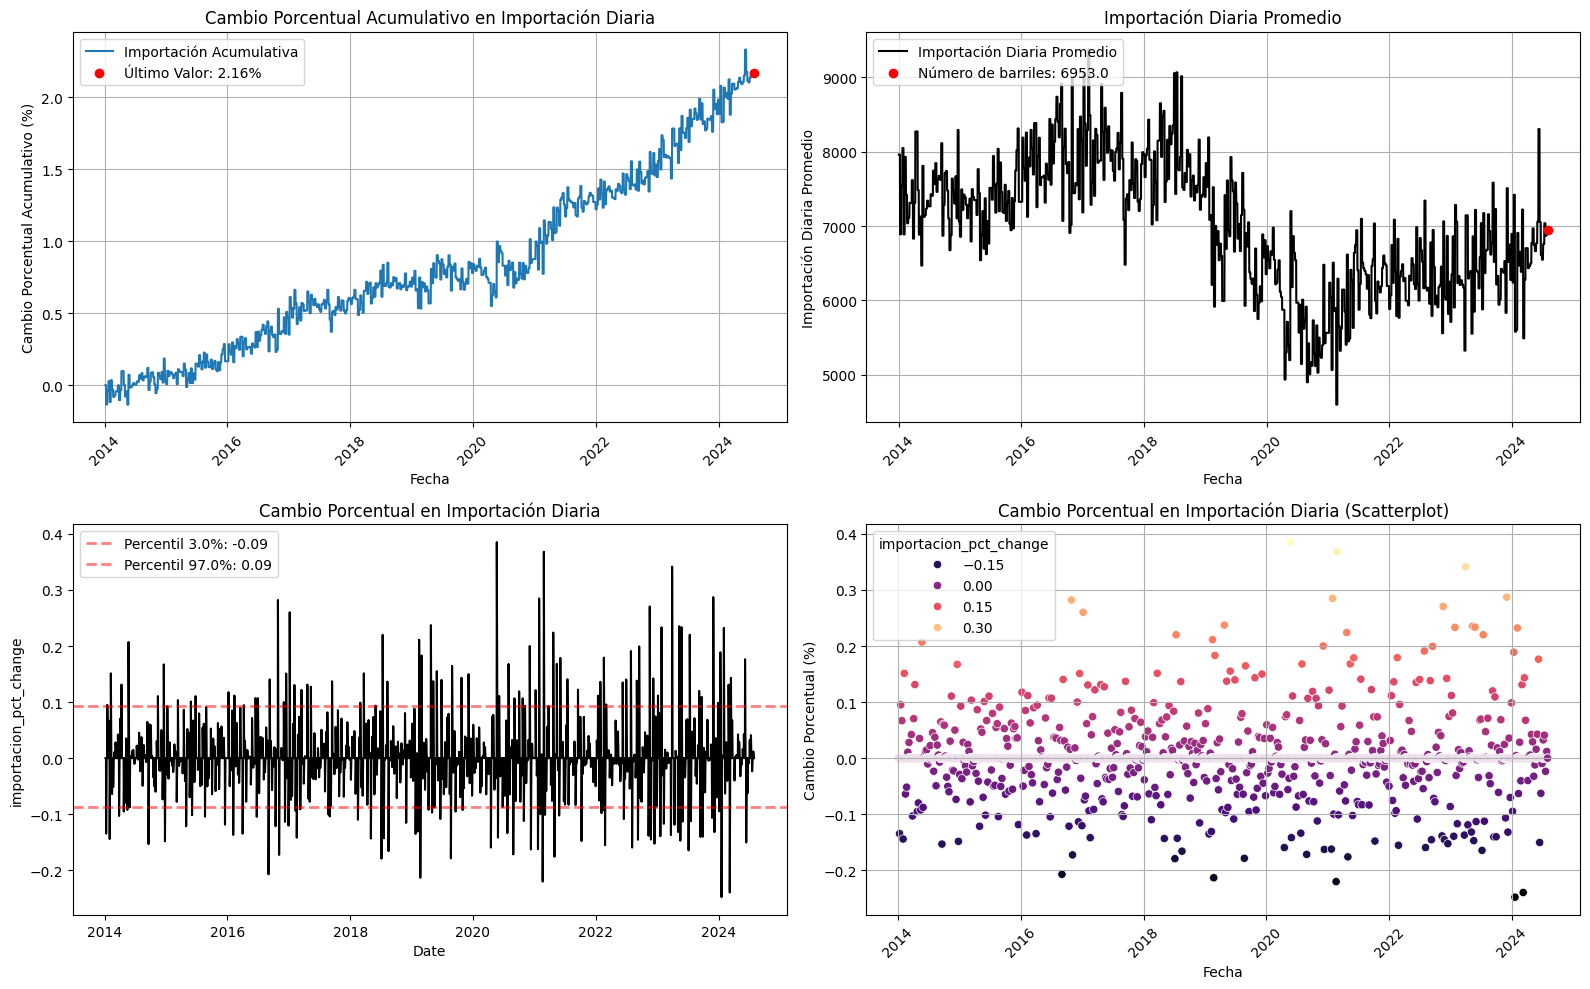

In [63]:
# Crear una figura con 4 subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Primer gráfico: Cambio porcentual acumulativo en la primera fila, primer gráfico
sns.lineplot(data=df, x='Date', y='importacion_cambio_acumulativo', label='Importación Acumulativa', ax=axs[0, 0])
ultimo_valor_acumulativo_importacion = df['importacion_cambio_acumulativo'].iloc[-1]
ultima_fecha_acumulativo_importacion = df['Date'].iloc[-1]
ultimo_valor_acumulativo_importacion_str = f"Último Valor: {ultimo_valor_acumulativo_importacion:.2f}%"
axs[0, 0].scatter(ultima_fecha_acumulativo_importacion, ultimo_valor_acumulativo_importacion, color='red', label=ultimo_valor_acumulativo_importacion_str, zorder=5)
axs[0, 0].legend(loc='upper left')
axs[0, 0].set_title('Cambio Porcentual Acumulativo en Importación Diaria')
axs[0, 0].set_ylabel('Cambio Porcentual Acumulativo (%)')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].grid(True)

# Segundo gráfico: Importación diaria promedio en la primera fila, segundo gráfico
sns.lineplot(data=df, x='Date', y='importacion_diaria_promedio', color="black", label='Importación Diaria Promedio', ax=axs[0, 1])
ultimo_valor_importacion = df['importacion_diaria_promedio'].iloc[-1]
ultima_fecha_importacion = df['Date'].iloc[-1]
ultimo_valor_importacion_str = f"Número de barriles: {ultimo_valor_importacion}"
axs[0, 1].scatter(ultima_fecha_importacion, ultimo_valor_importacion, color='red', label=ultimo_valor_importacion_str, zorder=5)
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title('Importación Diaria Promedio')
axs[0, 1].set_ylabel('Importación Diaria Promedio')
axs[0, 1].set_xlabel('Fecha')
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].grid(True)

# Tercer gráfico: Línea de cambio porcentual con percentiles, segunda fila, primer gráfico
sns.lineplot(data=df, x="Date", y="importacion_pct_change", color="black", ax=axs[1, 0])
axs[1, 0].axhline(y=percentil_3_importacion, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Percentil 3.0%: {percentil_3_importacion:.2f}')
axs[1, 0].axhline(y=percentil_96_importacion, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Percentil 97.0%: {percentil_96_importacion:.2f}')
axs[1, 0].set_title('Cambio Porcentual en Importación Diaria')
axs[1, 0].legend(loc='upper left')

# Cuarto gráfico: Scatterplot con la paleta "magma", segunda fila, segundo gráfico
sns.scatterplot(data=df, x='Date', y='importacion_pct_change', hue="importacion_pct_change", palette="magma", ax=axs[1, 1])
axs[1, 1].set_title('Cambio Porcentual en Importación Diaria (Scatterplot)')
axs[1, 1].set_ylabel('Cambio Porcentual (%)')
axs[1, 1].set_xlabel('Fecha')
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [64]:
# Agrupar los datos por semana y año, obteniendo la media de importación diaria por semana
df_semanal_importacion = df.groupby(['year', 'week']).agg(
    importacion_semanal=('importacion_diaria_promedio', 'mean'),
    fecha_inicio=('Date', 'min'),  # Fecha de inicio de la semana
    fecha_fin=('Date', 'max')  # Fecha de fin de la semana
).reset_index()

# Calcular la diferencia semanal en la importación
df_semanal_importacion['importacion_diff'] = df_semanal_importacion['importacion_semanal'].diff()

# Identificar rachas de crecimiento (+1) o disminución (-1) por semana
df_semanal_importacion['racha'] = np.sign(df_semanal_importacion['importacion_diff'])

# Identificar rachas consecutivas semanales
df_semanal_importacion['racha_id'] = (df_semanal_importacion['racha'] != df_semanal_importacion['racha'].shift(1)).cumsum()

# Agrupar por racha_id, capturando la importación inicial y final
rachas_semanales_importacion = df_semanal_importacion.groupby('racha_id').agg(
    racha_tipo=('racha', 'first'),  # Tipo de racha: crecimiento o disminución
    duracion=('racha', 'count'),    # Duración de la racha semanal
    fecha_inicio=('fecha_inicio', 'first'),  # Fecha de inicio de la racha
    fecha_fin=('fecha_fin', 'last'),  # Fecha de fin de la racha
    importacion_inicio=('importacion_semanal', 'first'),  # Importación al inicio de la racha
    importacion_fin=('importacion_semanal', 'last')  # Importación al final de la racha
).reset_index()

# Calcular el cambio en barriles y el porcentaje de cambio para importación
rachas_semanales_importacion['cambio_barriles'] = rachas_semanales_importacion['importacion_fin'] - rachas_semanales_importacion['importacion_inicio']
rachas_semanales_importacion['cambio_pct'] = (rachas_semanales_importacion['cambio_barriles'] / rachas_semanales_importacion['importacion_inicio']) * 100

# Redondear el porcentaje de cambio a 2 decimales
rachas_semanales_importacion["cambio_pct"] = rachas_semanales_importacion["cambio_pct"].round(2)

# Mostrar las rachas más largas
top_rachas_semanales_importacion = rachas_semanales_importacion.sort_values(by="duracion", ascending=False)
top_5_positivas_importacion = top_rachas_semanales_importacion[top_rachas_semanales_importacion["racha_tipo"] == 1.0].head(10)
top_5_negativas_importacion = top_rachas_semanales_importacion[top_rachas_semanales_importacion["racha_tipo"] == -1.0].head(10)

In [65]:
# Lista de pares de fechas de inicio y fin de top rachas importacion.
fechas_inicio_fin = [
    ('2021-12-06', '2022-01-07'),
    ('2020-06-15', '2020-07-17'),
    ('2021-07-26', '2021-08-27'),
    ('2020-03-23', '2020-04-24'),
    ('2019-09-23', '2019-10-25')
]

# Recorrer la lista de fechas para calcular el porcentaje de cambio para cada par en la variable importación
for fecha_inicio, fecha_fin in fechas_inicio_fin:
        # Filtrar los valores de 'importacion_diaria_promedio' para las fechas específicas
        valor_inicial = df.loc[df['Date'] == fecha_inicio, 'importacion_diaria_promedio'].values[0]
        valor_final = df.loc[df['Date'] == fecha_fin, 'importacion_diaria_promedio'].values[0]
        
        # Calcular el porcentaje de cambio
        porcentaje_cambio = ((valor_final - valor_inicial) / valor_inicial) * 100
        
        # Mostrar el resultado
        print(f"El porcentaje de cambio del CL entre {fecha_inicio} y {fecha_fin} es: {porcentaje_cambio:.2f}%")
top_rachas_semanales_importacion.head()


El porcentaje de cambio del CL entre 2021-12-06 y 2022-01-07 es: -6.62%
El porcentaje de cambio del CL entre 2020-06-15 y 2020-07-17 es: -10.55%
El porcentaje de cambio del CL entre 2021-07-26 y 2021-08-27 es: -2.57%
El porcentaje de cambio del CL entre 2020-03-23 y 2020-04-24 es: -13.32%
El porcentaje de cambio del CL entre 2019-09-23 y 2019-10-25 es: 5.00%


,racha_id,racha_tipo,duracion,fecha_inicio,fecha_fin,importacion_inicio,importacion_fin,cambio_barriles,cambio_pct
240,241,-1.0,5,2021-12-06,2022-01-07,6493.4,5921.0,-572.4,-8.82
198,199,-1.0,5,2020-06-15,2020-07-17,6621.6,5641.8,-979.8,-14.80
232,233,-1.0,5,2021-07-26,2021-08-27,6492.0,6193.6,-298.4,-4.60
192,193,-1.0,5,2020-03-23,2020-04-24,6103.0,5010.0,-1093.0,-17.91
180,181,-1.0,5,2019-09-23,2019-10-25,6360.6,6025.0,-335.6,-5.28


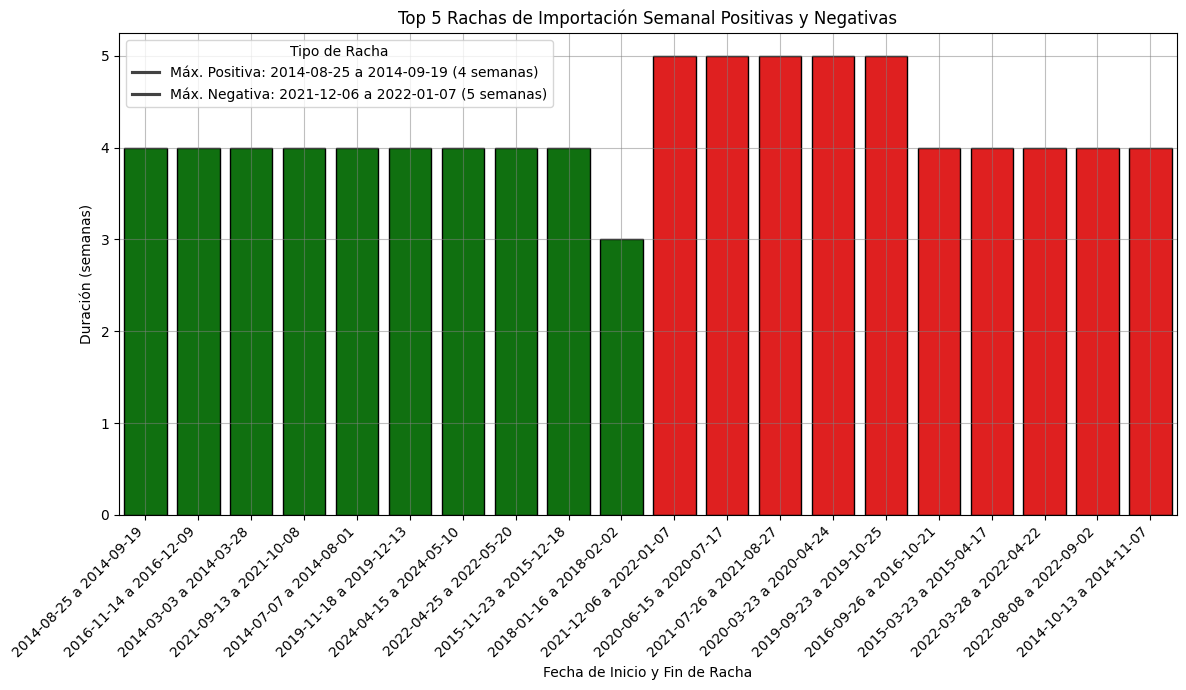

In [66]:
# Encontrar la racha más larga positiva y negativa en importación
racha_max_positiva_importacion = top_5_positivas_importacion.loc[top_5_positivas_importacion['duracion'].idxmax()]
racha_max_negativa_importacion = top_5_negativas_importacion.loc[top_5_negativas_importacion['duracion'].idxmax()]

# Concatenar las 5 mejores rachas positivas y negativas
top_5_rachas_importacion = pd.concat([top_5_positivas_importacion, top_5_negativas_importacion])

# Crear una nueva columna que combine la fecha de inicio y fin como etiquetas
top_5_rachas_importacion['fecha_racha'] = top_5_rachas_importacion['fecha_inicio'].dt.strftime('%Y-%m-%d') + ' a ' + top_5_rachas_importacion['fecha_fin'].dt.strftime('%Y-%m-%d')

# Crear un gráfico de barras usando las fechas como etiquetas en el eje x
plt.figure(figsize=(12, 7))
sns.barplot(data=top_5_rachas_importacion, x='fecha_racha', y='duracion', edgecolor="Black", hue='racha_tipo', palette=['red', 'green'])

# Añadir títulos y etiquetas
plt.title('Top 5 Rachas de Importación Semanal Positivas y Negativas')
plt.xlabel('Fecha de Inicio y Fin de Racha')
plt.ylabel('Duración (semanas)')

# Variables para fechas en el eje "X"
max_positiva_text_importacion = f"Máx. Positiva: {racha_max_positiva_importacion['fecha_inicio'].strftime('%Y-%m-%d')} a {racha_max_positiva_importacion['fecha_fin'].strftime('%Y-%m-%d')} ({racha_max_positiva_importacion['duracion']} semanas)"
max_negativa_text_importacion = f"Máx. Negativa: {racha_max_negativa_importacion['fecha_inicio'].strftime('%Y-%m-%d')} a {racha_max_negativa_importacion['fecha_fin'].strftime('%Y-%m-%d')} ({racha_max_negativa_importacion['duracion']} semanas)"
plt.legend(title='Tipo de Racha', loc='upper left', labels=[max_positiva_text_importacion, max_negativa_text_importacion])

plt.grid(alpha=0.5, color="gray")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Análisis de la exportación.

In [67]:
# Calcular el cambio porcentual acumulativo para la exportación
df['exportacion_cambio_acumulativo'] = (1 + df['exportacion_pct_change'] / 100).cumprod() - 1

# Multiplicamos por 100 para expresar el resultado como porcentaje
df['exportacion_cambio_acumulativo'] = df['exportacion_cambio_acumulativo'] * 100

# Calcular los percentiles para exportacion_pct_change
percentil_3_exportacion = df["exportacion_pct_change"].quantile(0.02)
percentil_96_exportacion = df["exportacion_pct_change"].quantile(0.98)

# Descripción estadística de la exportación diaria promedio
df['exportacion_diaria_promedio'].describe()


count    2662.000000
mean     2193.439519
std      1513.120452
min        58.000000
25%       549.000000
50%      2362.000000
75%      3363.000000
max      5629.000000
Name: exportacion_diaria_promedio, dtype: float64

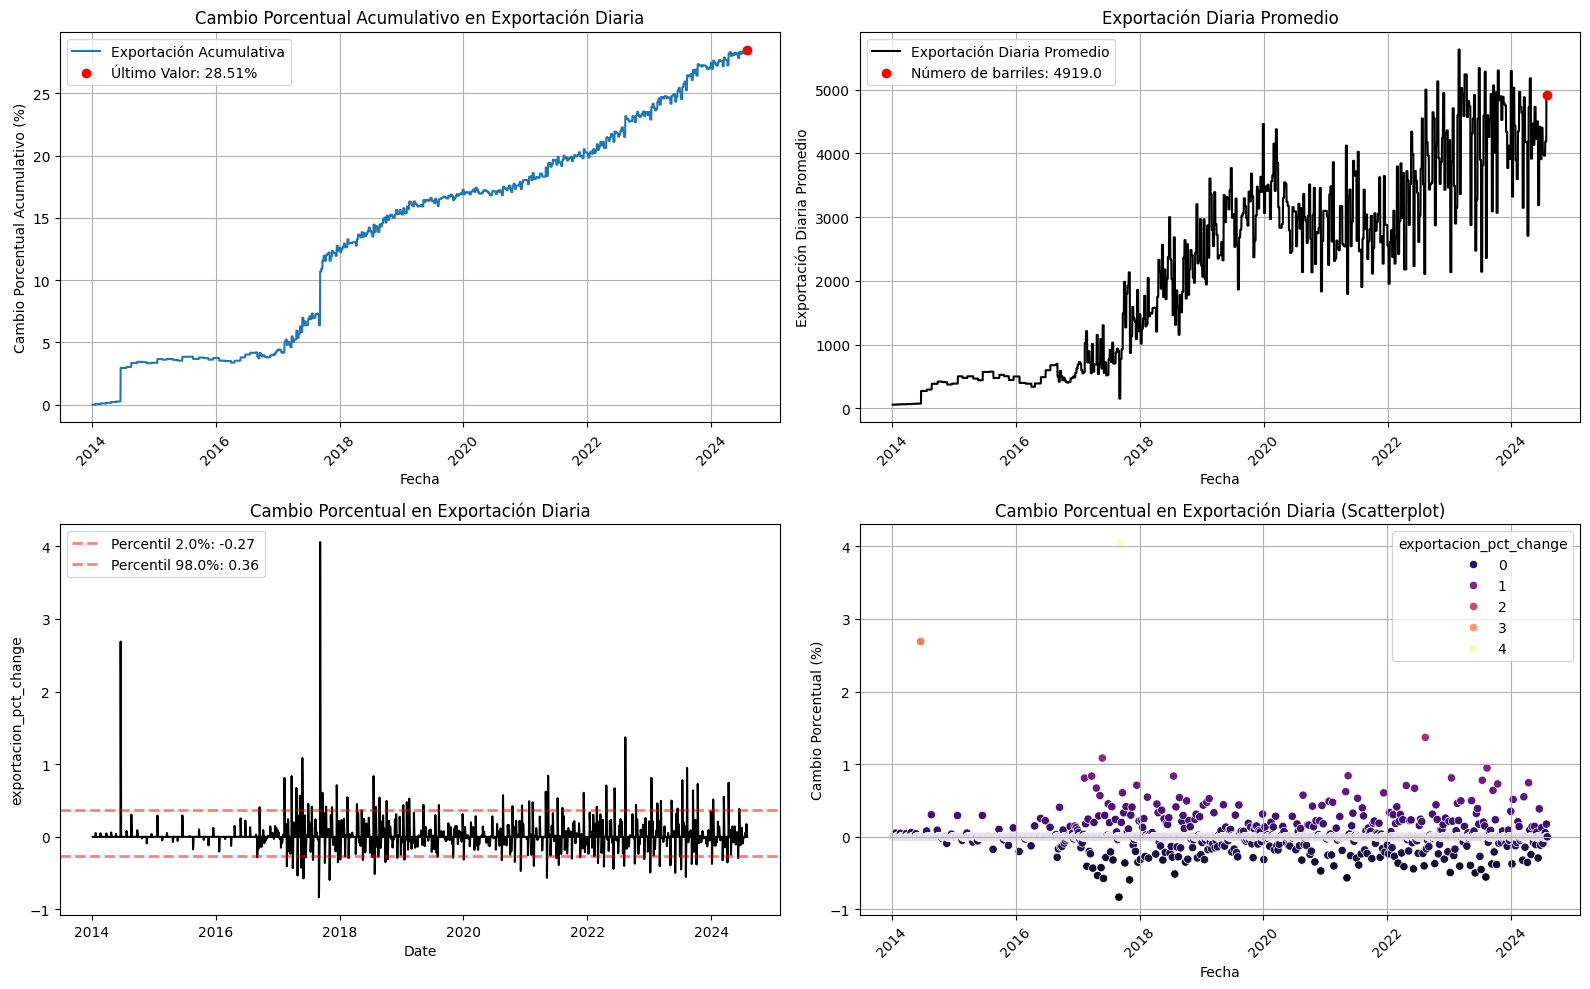

In [68]:
# Crear una figura con 4 subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Primer gráfico: Cambio porcentual acumulativo en la primera fila, primer gráfico
sns.lineplot(data=df, x='Date', y='exportacion_cambio_acumulativo', label='Exportación Acumulativa', ax=axs[0, 0])
ultimo_valor_acumulativo_exportacion = df['exportacion_cambio_acumulativo'].iloc[-1]
ultima_fecha_acumulativo_exportacion = df['Date'].iloc[-1]
ultimo_valor_acumulativo_exportacion_str = f"Último Valor: {ultimo_valor_acumulativo_exportacion:.2f}%"
axs[0, 0].scatter(ultima_fecha_acumulativo_exportacion, ultimo_valor_acumulativo_exportacion, color='red', label=ultimo_valor_acumulativo_exportacion_str, zorder=5)
axs[0, 0].legend(loc='upper left')
axs[0, 0].set_title('Cambio Porcentual Acumulativo en Exportación Diaria')
axs[0, 0].set_ylabel('Cambio Porcentual Acumulativo (%)')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].grid(True)

# Segundo gráfico: Exportación diaria promedio en la primera fila, segundo gráfico
sns.lineplot(data=df, x='Date', y='exportacion_diaria_promedio', color="black", label='Exportación Diaria Promedio', ax=axs[0, 1])
ultimo_valor_exportacion = df['exportacion_diaria_promedio'].iloc[-1]
ultima_fecha_exportacion = df['Date'].iloc[-1]
ultimo_valor_exportacion_str = f"Número de barriles: {ultimo_valor_exportacion}"
axs[0, 1].scatter(ultima_fecha_exportacion, ultimo_valor_exportacion, color='red', label=ultimo_valor_exportacion_str, zorder=5)
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title('Exportación Diaria Promedio')
axs[0, 1].set_ylabel('Exportación Diaria Promedio')
axs[0, 1].set_xlabel('Fecha')
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].grid(True)

# Tercer gráfico: Línea de cambio porcentual con percentiles, segunda fila, primer gráfico
sns.lineplot(data=df, x="Date", y="exportacion_pct_change", color="black", ax=axs[1, 0])
axs[1, 0].axhline(y=percentil_3_exportacion, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Percentil 2.0%: {percentil_3_exportacion:.2f}')
axs[1, 0].axhline(y=percentil_96_exportacion, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Percentil 98.0%: {percentil_96_exportacion:.2f}')
axs[1, 0].set_title('Cambio Porcentual en Exportación Diaria')
axs[1, 0].legend(loc='upper left')

# Cuarto gráfico: Scatterplot con la paleta "magma", segunda fila, segundo gráfico
sns.scatterplot(data=df, x='Date', y='exportacion_pct_change', hue="exportacion_pct_change", palette="magma", ax=axs[1, 1])
axs[1, 1].set_title('Cambio Porcentual en Exportación Diaria (Scatterplot)')
axs[1, 1].set_ylabel('Cambio Porcentual (%)')
axs[1, 1].set_xlabel('Fecha')
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [69]:
# Agrupar los datos por semana y año, obteniendo la media de exportación diaria por semana
df_semanal_exportacion = df.groupby(['year', 'week']).agg(
    exportacion_semanal=('exportacion_diaria_promedio', 'mean'),
    fecha_inicio=('Date', 'min'),  # Fecha de inicio de la semana
    fecha_fin=('Date', 'max')  # Fecha de fin de la semana
).reset_index()

# Calcular la diferencia semanal en la exportación
df_semanal_exportacion['exportacion_diff'] = df_semanal_exportacion['exportacion_semanal'].diff()

# Identificar rachas de crecimiento (+1) o disminución (-1) por semana
df_semanal_exportacion['racha'] = np.sign(df_semanal_exportacion['exportacion_diff'])

# Identificar rachas consecutivas semanales
df_semanal_exportacion['racha_id'] = (df_semanal_exportacion['racha'] != df_semanal_exportacion['racha'].shift(1)).cumsum()

# Agrupar por racha_id, capturando la exportación inicial y final
rachas_semanales_exportacion = df_semanal_exportacion.groupby('racha_id').agg(
    racha_tipo=('racha', 'first'),  # Tipo de racha: crecimiento o disminución
    duracion=('racha', 'count'),    # Duración de la racha semanal
    fecha_inicio=('fecha_inicio', 'first'),  # Fecha de inicio de la racha
    fecha_fin=('fecha_fin', 'last'),  # Fecha de fin de la racha
    exportacion_inicio=('exportacion_semanal', 'first'),  # Exportación al inicio de la racha
    exportacion_fin=('exportacion_semanal', 'last')  # Exportación al final de la racha
).reset_index()

# Calcular el cambio en barriles y el porcentaje de cambio para exportación
rachas_semanales_exportacion['cambio_barriles'] = rachas_semanales_exportacion['exportacion_fin'] - rachas_semanales_exportacion['exportacion_inicio']
rachas_semanales_exportacion['cambio_pct'] = (rachas_semanales_exportacion['cambio_barriles'] / rachas_semanales_exportacion['exportacion_inicio']) * 100

# Redondear el porcentaje de cambio a 2 decimales
rachas_semanales_exportacion["cambio_pct"] = rachas_semanales_exportacion["cambio_pct"].round(2)

# Mostrar las rachas más largas
top_rachas_semanales_exportacion = rachas_semanales_exportacion.sort_values(by="duracion", ascending=False)
top_5_positivas_exportacion = top_rachas_semanales_exportacion[top_rachas_semanales_exportacion["racha_tipo"] == 1.0].head(10)
top_5_negativas_exportacion = top_rachas_semanales_exportacion[top_rachas_semanales_exportacion["racha_tipo"] == -1.0].head(10)

In [70]:
# Lista de pares de fechas de inicio y fin de las top rachas de exportación
fechas_inicio_fin = [
    ('2016-11-07', '2017-01-13'),
    ('2019-08-12', '2019-09-13'),
    ('2020-05-11', '2020-06-12'),
    ('2019-12-09', '2020-01-03'),
    ('2021-12-20', '2022-01-14')
]

# Recorrer la lista de fechas para calcular el porcentaje de cambio para cada par en la variable exportación
for fecha_inicio, fecha_fin in fechas_inicio_fin:
        # Filtrar los valores de 'exportacion_diaria_promedio' para las fechas específicas
        valor_inicial = df.loc[df['Date'] == fecha_inicio, 'exportacion_diaria_promedio'].values[0]
        valor_final = df.loc[df['Date'] == fecha_fin, 'exportacion_diaria_promedio'].values[0]

        # Calcular el porcentaje de cambio
        porcentaje_cambio = ((valor_final - valor_inicial) / valor_inicial) * 100

        # Mostrar el resultado
        print(f"El porcentaje de cambio del CL entre {fecha_inicio} y {fecha_fin} es: {porcentaje_cambio:.2f}%")

top_rachas_semanales_exportacion.head()

El porcentaje de cambio del CL entre 2016-11-07 y 2017-01-13 es: 71.71%
El porcentaje de cambio del CL entre 2019-08-12 y 2019-09-13 es: 18.34%
El porcentaje de cambio del CL entre 2020-05-11 y 2020-06-12 es: -30.16%
El porcentaje de cambio del CL entre 2019-12-09 y 2020-01-03 es: -9.88%
El porcentaje de cambio del CL entre 2021-12-20 y 2022-01-14 es: -9.34%


,racha_id,racha_tipo,duracion,fecha_inicio,fecha_fin,exportacion_inicio,exportacion_fin,cambio_barriles,cambio_pct
70,71,1.0,10,2016-11-07,2017-01-13,410.0,722.4,312.4,76.20
150,151,1.0,5,2019-08-12,2019-09-13,2707.0,3271.0,564.0,20.83
169,170,-1.0,5,2020-05-11,2020-06-12,3467.8,2443.6,-1024.2,-29.53
158,159,1.0,4,2019-12-09,2020-01-03,3446.6,4112.5,665.9,19.32
214,215,-1.0,4,2021-12-20,2022-01-14,2879.0,2086.0,-793.0,-27.54


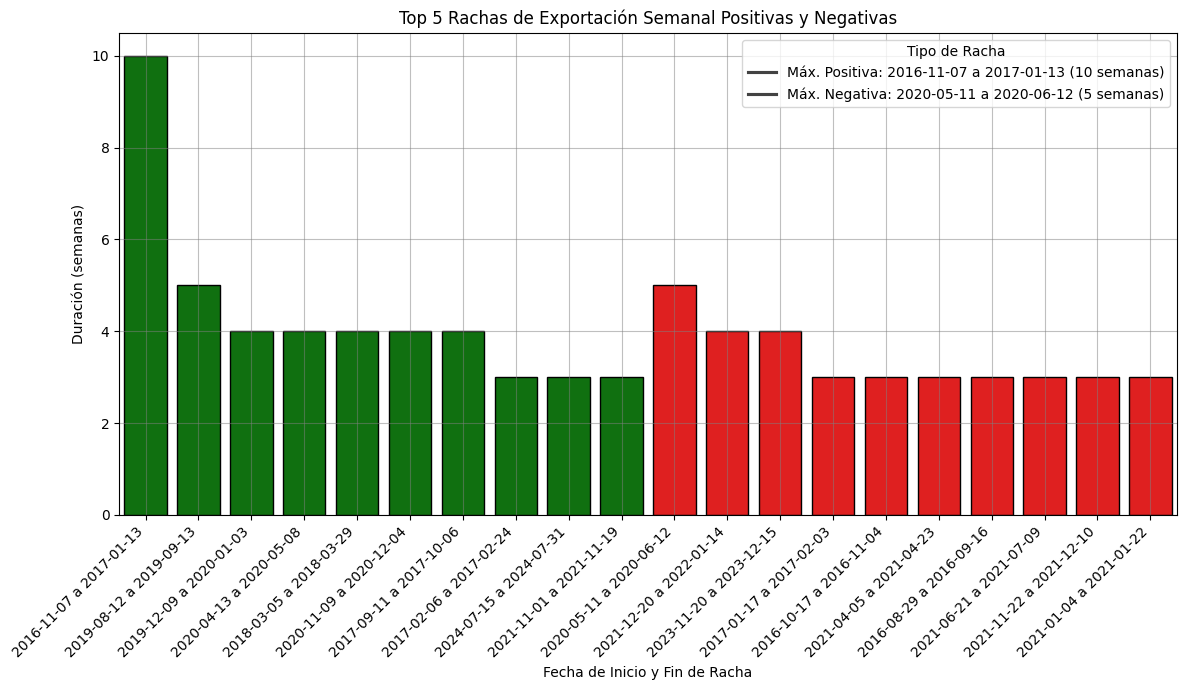

In [71]:
# Encontrar la racha más larga positiva y negativa en exportación
racha_max_positiva_exportacion = top_5_positivas_exportacion.loc[top_5_positivas_exportacion['duracion'].idxmax()]
racha_max_negativa_exportacion = top_5_negativas_exportacion.loc[top_5_negativas_exportacion['duracion'].idxmax()]

# Concatenar las 5 mejores rachas positivas y negativas
top_5_rachas_exportacion = pd.concat([top_5_positivas_exportacion, top_5_negativas_exportacion])

# Crear una nueva columna que combine la fecha de inicio y fin como etiquetas
top_5_rachas_exportacion['fecha_racha'] = top_5_rachas_exportacion['fecha_inicio'].dt.strftime('%Y-%m-%d') + ' a ' + top_5_rachas_exportacion['fecha_fin'].dt.strftime('%Y-%m-%d')

# Crear un gráfico de barras usando las fechas como etiquetas en el eje x
plt.figure(figsize=(12, 7))
sns.barplot(data=top_5_rachas_exportacion, x='fecha_racha', y='duracion', edgecolor="Black", hue='racha_tipo', palette=['red', 'green'])

# Añadir títulos y etiquetas
plt.title('Top 5 Rachas de Exportación Semanal Positivas y Negativas')
plt.xlabel('Fecha de Inicio y Fin de Racha')
plt.ylabel('Duración (semanas)')

# Variables para fechas en el eje "X"
max_positiva_text_exportacion = f"Máx. Positiva: {racha_max_positiva_exportacion['fecha_inicio'].strftime('%Y-%m-%d')} a {racha_max_positiva_exportacion['fecha_fin'].strftime('%Y-%m-%d')} ({racha_max_positiva_exportacion['duracion']} semanas)"
max_negativa_text_exportacion = f"Máx. Negativa: {racha_max_negativa_exportacion['fecha_inicio'].strftime('%Y-%m-%d')} a {racha_max_negativa_exportacion['fecha_fin'].strftime('%Y-%m-%d')} ({racha_max_negativa_exportacion['duracion']} semanas)"
plt.legend(title='Tipo de Racha', loc='upper right', labels=[max_positiva_text_exportacion, max_negativa_text_exportacion])

plt.grid(alpha=0.5, color="gray")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Análisis del inventario semanal (WIP)

<Axes: xlabel='Date', ylabel='inventario_final_semanal'>

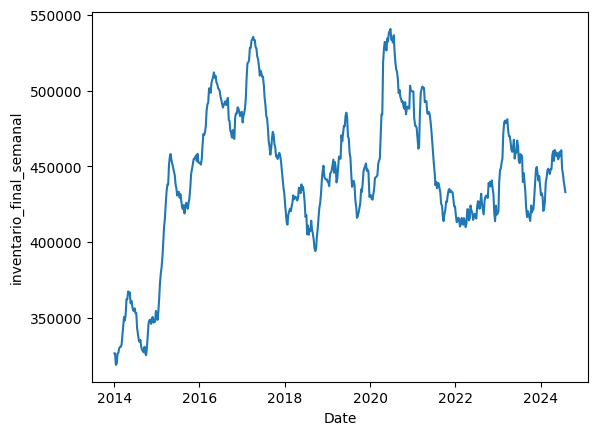

In [72]:
sns.lineplot(data=df, x="Date", y="inventario_final_semanal")

## Analisis del porcentaje de cambio y probabilidad de cierres consecutivos negativos o positivos.

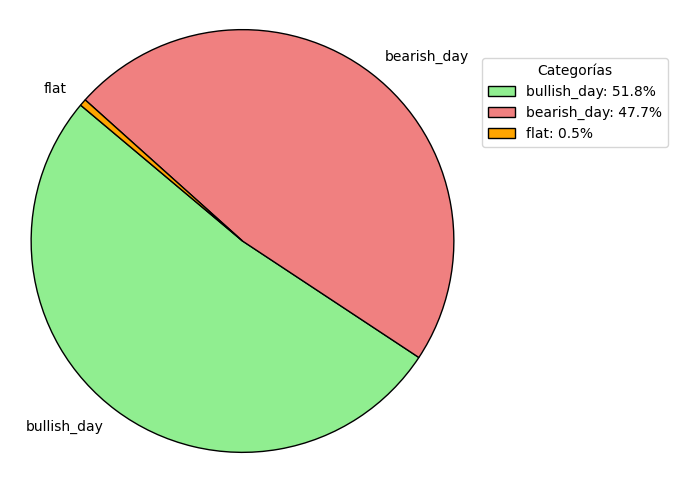

In [73]:
# Definir los colores.
colors = ['lightgreen', 'lightcoral', 'orange'] 

# Obtener los valores y etiquetas
k = df["bullish_bearish_day"].value_counts()
labels = k.index
# Calcular los porcentajes
porcentajes = 100 * k / k.sum()

# Crear las etiquetas con los porcentajes
labels_with_percentages = [f'{label}: {pct:.1f}%' for label, pct in zip(labels, porcentajes)]
plt.figure(figsize=(6,6))
# Crear el gráfico de pastel con colores personalizados y bordes negros
plt.pie(k, labels=labels, startangle=140, 
        colors=colors, wedgeprops={'edgecolor': 'black'})  # Colores pastel y bordes negros

plt.legend(labels_with_percentages, loc='center left', bbox_to_anchor=(1, 0.8), title="Categorías")
plt.axis('equal')
plt.show()


### Distribución binomial  función de masa PMF.

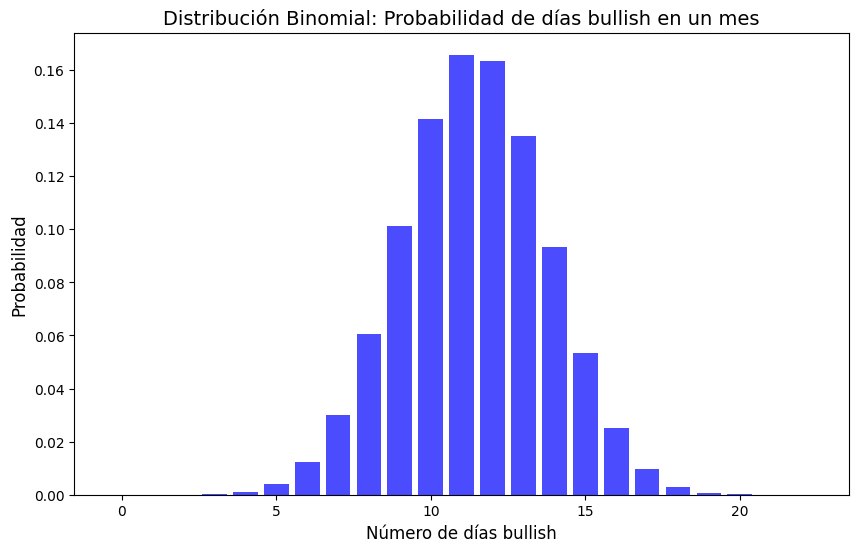

Hay una probabilidad de 0.0 de cerrar: 1 días positivo al mes.
Hay una probabilidad de 0.0 de cerrar: 2 días positivo al mes.
Hay una probabilidad de 0.0 de cerrar: 3 días positivo al mes.
Hay una probabilidad de 0.0002 de cerrar: 4 días positivo al mes.
Hay una probabilidad de 0.001 de cerrar: 5 días positivo al mes.
Hay una probabilidad de 0.004 de cerrar: 6 días positivo al mes.
Hay una probabilidad de 0.0122 de cerrar: 7 días positivo al mes.
Hay una probabilidad de 0.03 de cerrar: 8 días positivo al mes.
Hay una probabilidad de 0.0605 de cerrar: 9 días positivo al mes.
Hay una probabilidad de 0.1012 de cerrar: 10 días positivo al mes.
Hay una probabilidad de 0.1414 de cerrar: 11 días positivo al mes.
Hay una probabilidad de 0.1658 de cerrar: 12 días positivo al mes.
Hay una probabilidad de 0.1633 de cerrar: 13 días positivo al mes.
Hay una probabilidad de 0.135 de cerrar: 14 días positivo al mes.
Hay una probabilidad de 0.0933 de cerrar: 15 días positivo al mes.
Hay una probabilid

In [74]:
# Parámetros según tu contexto
n = 22  # Número de intentos (días consecutivos, que representan un mes)
p = 1380 / 2664  # Probabilidad de éxito (días bullish basado en tus datos)
k_values = np.arange(0, n + 1)  # Valores posibles de éxitos (de 0 a n)

# Calcular la función de masa de probabilidad (PMF) para cada valor de k
probabilidades = binom.pmf(k_values, n, p)

# Crear el histograma de la distribución binomial
plt.figure(figsize=(10, 6))
plt.bar(k_values, probabilidades, color='blue', alpha=0.7)

# Etiquetas y título
plt.title('Distribución Binomial: Probabilidad de días bullish en un mes', fontsize=14)
plt.xlabel('Número de días bullish', fontsize=12)
plt.ylabel('Probabilidad', fontsize=12)

# Mostrar el gráfico
plt.show()

# Configurar la visualización sin notación científica
np.set_printoptions(suppress=True)

# Mostrar las probabilidades junto con los valores correspondientes de k
probabilidades_lista = [(k, prob) for k, prob in zip(k_values, probabilidades)]
probabilidades_lista.pop(0)

n_dias = 1
for dato in probabilidades.round(4):
    print(f"Hay una probabilidad de {dato} de cerrar: {n_dias} días positivo al mes.")
    n_dias = n_dias + 1

### Generamos el filtrado para obtener las rachas  positivas, negativas y totales (Días seguidos alcistas o bajistas):
 - Con la fecha de inicio y final de la racha.
 - El numero de días consecutivos de la racha.
 - La  media de porcentaje de cambio de la racha.
 - El porcentaje de cambio total de la racha
 - La volitalidad promedio de la racha.

In [75]:
# Calcula la diferencia diaria en "Change"
df["Change_diff"] = df["Change"].diff()

# Asigna 1 si el cambio es positivo, -1 si es negativo, y 0 si no hay cambio
df["racha_change"] = np.sign(df["Change_diff"])

# Identifica rachas de cambios acumulando un ID único cuando cambia la tendencia
df['racha_change_id'] = (df['racha_change'] != df['racha_change'].shift(1)).cumsum()


In [76]:
#Filtrado para entenderel comportamiento de las rachas positivas y negativas.
rachas = df.groupby("racha_change_id").agg(
    fecha_inicio = ("Date", "first"),
    fecha_final = ("Date", "last"),
    racha_del_rango = ("racha_change", "count"),
    media_porcentaje_cambio_diario = ("Change", "mean"),
    porcentaje_total_cambio_racha = ("Change", "sum"),
    volatilidad_media = ("volatility", "mean"),

)
rachas.sort_values(ascending=False, by="racha_del_rango")

#Filtrado rachas positivas y negativas
rachas_positivas = rachas[rachas["porcentaje_total_cambio_racha"] > 0]
rachas_negativas = rachas[rachas["porcentaje_total_cambio_racha"] < 0]

#Print de las rachas de mayor a menor
rachas.sort_values("racha_del_rango", ascending=False)


,fecha_inicio,fecha_final,racha_del_rango,media_porcentaje_cambio_diario,porcentaje_total_cambio_racha,volatilidad_media
racha_change_id,,,,,,
1297,2021-08-11,2021-08-18,6,-0.691667,-4.15,1.336667
592,2017-06-21,2017-06-28,6,0.598333,3.59,1.251667
771,2018-06-27,2018-07-05,6,0.716667,4.30,1.595000
453,2016-08-26,2016-09-01,5,-1.676000,-8.38,1.606000
1504,2022-12-07,2022-12-13,5,-0.210000,-1.05,1.928000
...,...,...,...,...,...,...
720,2018-03-23,2018-03-23,1,2.490000,2.49,1.910000
719,2018-03-22,2018-03-22,1,-1.830000,-1.83,1.810000
717,2018-03-19,2018-03-19,1,-0.270000,-0.27,1.090000


### Estadisticas del porcentaje de cambio de los dias  dentro de cada racha alcista.

In [77]:
#Filtramos por el rango de la racha
rachas_positivas_1 = rachas_positivas[rachas_positivas["racha_del_rango"] == 1]
rachas_positivas_2 = rachas_positivas[rachas_positivas["racha_del_rango"] == 2]
rachas_positivas_3 = rachas_positivas[rachas_positivas["racha_del_rango"] == 3]
rachas_positivas_4 = rachas_positivas[rachas_positivas["racha_del_rango"] == 4]
rachas_positivas_5 = rachas_positivas[rachas_positivas["racha_del_rango"] == 5]
rachas_positivas_6 = rachas_positivas[rachas_positivas["racha_del_rango"] == 6]

#Print de las estadísticas
print("Estadísticas de las rachas positivas de 1 solo día:\n", rachas_positivas_1["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas positivas de 2 días:\n", rachas_positivas_2["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas positivas de 3 días:\n", rachas_positivas_3["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas positivas de 4 días:\n", rachas_positivas_4["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas positivas de 5 días:\n", rachas_positivas_5["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas positivas de 6 días:\n", rachas_positivas_6["media_porcentaje_cambio_diario"].describe())

Estadísticas de las rachas positivas de 1 solo día:
 count    580.000000
mean       1.785017
std        1.801989
min        0.010000
25%        0.620000
50%        1.360000
75%        2.352500
max       19.320000
Name: media_porcentaje_cambio_diario, dtype: float64

Estadísticas de las rachas positivas de 2 días:
 count    251.000000
mean       1.255817
std        1.339739
min        0.010000
25%        0.465000
50%        0.935000
75%        1.557500
max       11.165000
Name: media_porcentaje_cambio_diario, dtype: float64

Estadísticas de las rachas positivas de 3 días:
 count    75.000000
mean      0.907822
std       1.145141
min       0.026667
25%       0.385000
50%       0.703333
75%       1.118333
max       9.496667
Name: media_porcentaje_cambio_diario, dtype: float64

Estadísticas de las rachas positivas de 4 días:
 count    11.000000
mean      0.606136
std       0.532888
min       0.060000
25%       0.311250
50%       0.437500
75%       0.728750
max       1.922500
Name: media_po

### Estadísticas del porcentaje de cambio de los dias  dentro de cada racha bajista.

In [78]:
# Filtramos por el rango de la racha
rachas_negativas_1 = rachas_negativas[rachas_negativas["racha_del_rango"] == 1]
rachas_negativas_2 = rachas_negativas[rachas_negativas["racha_del_rango"] == 2]
rachas_negativas_3 = rachas_negativas[rachas_negativas["racha_del_rango"] == 3]
rachas_negativas_4 = rachas_negativas[rachas_negativas["racha_del_rango"] == 4]
rachas_negativas_5 = rachas_negativas[rachas_negativas["racha_del_rango"] == 5]
rachas_negativas_6 = rachas_negativas[rachas_negativas["racha_del_rango"] == 6]

# Print de las estadísticas
print("Estadísticas de las rachas negativas de 1 solo día:\n", rachas_negativas_1["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas negativas de 2 días:\n", rachas_negativas_2["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas negativas de 3 días:\n", rachas_negativas_3["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas negativas de 4 días:\n", rachas_negativas_4["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas negativas de 5 días:\n", rachas_negativas_5["media_porcentaje_cambio_diario"].describe())
print("\nEstadísticas de las rachas negativas de 6 días:\n", rachas_negativas_6["media_porcentaje_cambio_diario"].describe())


Estadísticas de las rachas negativas de 1 solo día:
 count    551.000000
mean      -1.928947
std        2.122028
min      -24.390000
25%       -2.675000
50%       -1.230000
75%       -0.560000
max       -0.020000
Name: media_porcentaje_cambio_diario, dtype: float64

Estadísticas de las rachas negativas de 2 días:
 count    220.000000
mean      -1.390136
std        1.389966
min      -11.580000
25%       -2.052500
50%       -1.095000
75%       -0.435000
max       -0.005000
Name: media_porcentaje_cambio_diario, dtype: float64

Estadísticas de las rachas negativas de 3 días:
 count    63.000000
mean     -0.975979
std       0.876193
min      -4.126667
25%      -1.481667
50%      -0.736667
75%      -0.328333
max      -0.010000
Name: media_porcentaje_cambio_diario, dtype: float64

Estadísticas de las rachas negativas de 4 días:
 count    15.000000
mean     -0.941000
std       0.937839
min      -3.340000
25%      -1.240000
50%      -0.822500
75%      -0.183750
max      -0.067500
Name: media_po

### Distribución de rachas alcistas y bajistas.

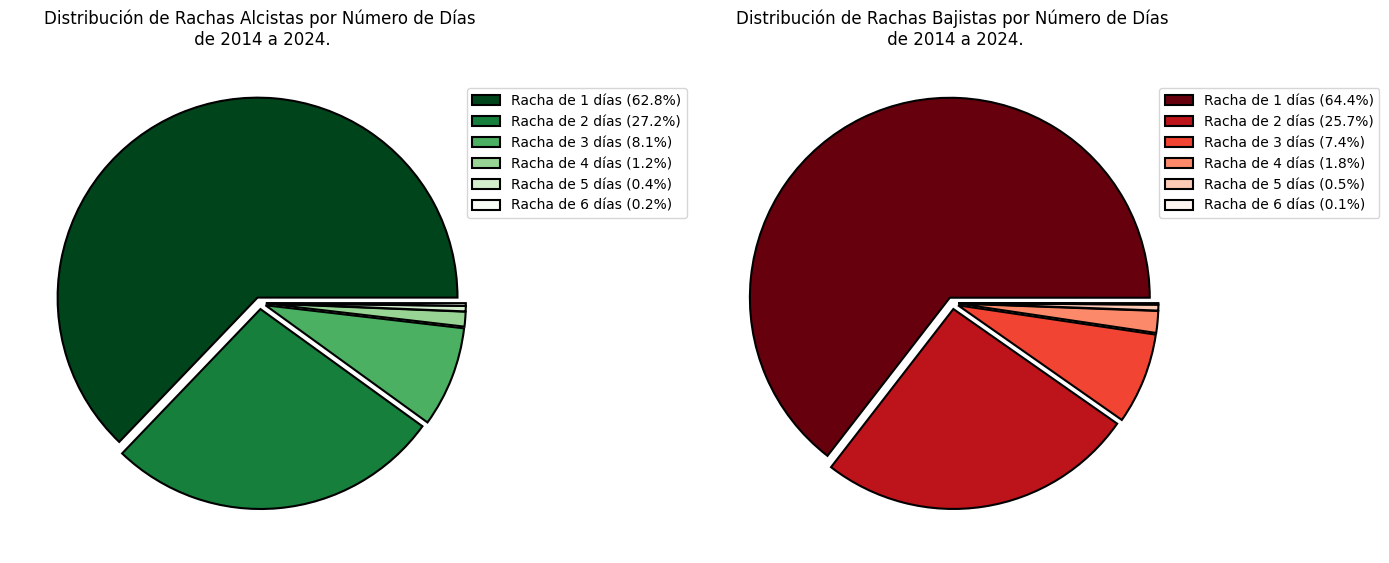

In [83]:
# Función para generar el gráfico de torta para cada conjunto de rachas
def plot_rachas_pie(ax, rachas_data, title, colormap_name):
    conteo_rachas = rachas_data["racha_del_rango"].value_counts()
    total_rachas = conteo_rachas.sum()
    prob_rachas = conteo_rachas / total_rachas
    
    # Verificar si existe una racha de valor 0 y eliminarla si está presente
    if 0 in prob_rachas.index:
        prob_rachas.drop([0], inplace=True)
    
    sizes = list(prob_rachas.values)  # Usar .values para obtener los valores
    explode = [0.03] * len(sizes)  # Explota todos los segmentos ligeramente

    # Calcular los porcentajes manualmente para añadirlos a la leyenda
    percentages = [f'{size * 100:.1f}%' for size in sizes]
    labels_with_percentages = [f'Racha de {key} días ({percentage})' for key, percentage in zip(prob_rachas.index, percentages)]

    # Usar un mapa de colores basado en el colormap especificado
    colormap = plt.get_cmap(colormap_name)
    colors = colormap(np.linspace(0, 1, len(sizes)))  # Crear un gradiente de colores

    # Crear el gráfico de torta en el eje especificado
    wedges, texts = ax.pie(sizes, colors=colors, explode=explode, 
                           wedgeprops={"linewidth": 1.5, "edgecolor": "black"}, labels=None)

    # Añadir la leyenda con porcentajes
    ax.legend(labels=labels_with_percentages, loc="center left", bbox_to_anchor=(0.9, 0.8), fontsize=10)
    ax.set_title(title)

# Crear una figura con dos gráficos de torta en un solo eje horizontal
fig, axs = plt.subplots(1, 2, figsize=(14, 7))  # Dos gráficos lado a lado

# Gráfico de torta para rachas positivas (usar colormap 'Greens_r')
plot_rachas_pie(axs[0], rachas_positivas, "Distribución de Rachas Alcistas por Número de Días\n de 2014 a 2024.", 'Greens_r')

# Gráfico de torta para rachas negativas (usar colormap 'Reds_r')
plot_rachas_pie(axs[1], rachas_negativas, "Distribución de Rachas Bajistas por Número de Días\n de 2014 a 2024.", 'Reds_r')
plt.tight_layout()
plt.show()